<a href="https://colab.research.google.com/github/Maxouuu4/test_git/blob/main/math0487_nb4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📓 Notebook 4 : **Estimation de paramètres 1/2 - estimation ponctuelle**

## Objectifs 🎯

Les objectifs de ce notebook sont les suivants :
- *comprendre* le concept d'estimateur de la méthode des moments (MoM) ;
- *savoir calculer* l'estimateur MoM ;
- *comprendre* le concept d'estimateur du maximum de vraisemblance (MLE) et ses propriétés ;
- *savoir calculer* le MLE.


## Contexte 🔍

Dans ce quatrième notebook, nous allons aborder différents concepts liés à l'estimation ponctuelle à l'aide de l'ensemble de données utilisé dans le second notebook.

Commençons par importer les librairies dont nous aurons besoin, puis chargeons les données dans une dataframe pandas. 👇

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
from scipy.stats import expon, gamma, norm, beta, gamma, gaussian_kde
from scipy.optimize import minimize
from scipy.special import psi, polygamma

import ipywidgets as widgets
from ipywidgets import Button, Output, VBox, HBox, Button, IntSlider, FloatSlider, Dropdown
from IPython.display import display, Math, clear_output

import torch
import numpy as np

In [ ]:
# Path to file for storing the data
file_path = "housing.csv"

# Creation of the DataFrame using downloaded data
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "camnugent/california-housing-prices",
  file_path,
)

/tmp/ipython-input-2373647902.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'california-housing-prices' dataset.


## Estimation de paramètres 🔮
Dans les deux notebooks précédents, nous avons premièrement vu comment explorer et décrire un échantillon de données, puis nous avons abordé la modélisation de ces données au moyen d'un modèle statistique. Pour rappel, nous avons vu que, pour modéliser une distribution empirique de données recueillies $\mathbf{y}$, on pouvait postuler divers modèles $f_{\mathbf{Y}}(\mathbf{y}; \mathbf{\theta})$, chacun indexé par un ou plusieurs paramètres, dénoté par $\mathbf{\theta}$, et qu'à chacun de ces modèles était associée une fonction de vraisemblance $L(\mathbf{\theta} ; \mathbf{y})$ pour les données observées.

Nous avons ainsi vu que, pour un échantillon $\mathbf{y}$ donné, et pour un modèle $f_{\mathbf{Y}}(\mathbf{y}; \mathbf{\theta})$ postulé, le choix du set de paramètres $\mathbf{\theta}$ modifiait la forme de la distribution associée et collait plus ou moins bien aux données de l'échantillon à notre disposition.

Ce troisième notebook se concentre assez logiquement sur l'étape suivante : comment **estimer le set de paramètres $\mathbf{\theta}$** à l'aide des données recueillies ?    

### Estimation ponctuelle 👇

Nous allons dans un premier temps nous intéresser aux méthodes d'estimation dite *ponctuelle*. Pourquoi ce terme ? Et bien, simplement parce que nous allons utiliser les données pour calculer une *valeur unique* pour chacun des paramètres libres du modèle, c'est-à-dire que nous allons sélectionner un *point* dans l'espace des paramètres.

Par exemple, pour les données $\mathbf{y}$ et un modèle quelconque $f_{\mathbf{Y}}(\mathbf{y} ; \mathbf{\theta})$ où le paramètre $\theta$ correspond également à la moyenne pour cette distribution, un estimateur ponctuel intuitif de $\theta$ est simplement donné par la moyenne de l'échantillon $\mathbf{y}$. L'estimateur est donc une variable aléatoire, notée
$$\hat{\theta} = \bar{\mathbf{y}}$$
et dont la valeur de cristallisation dépend des données récoltées. Pour les données $\mathbf{y} = (1, 3, -4, 8)$, on estimerait ainsi $\hat{\theta}=2$. $\hat{\theta}$ est notre "point" dans l'espace du paramètre $\theta$.

📌 La méthode utilisée ci-dessous correspond en réalité à la première méthode que nous allons étudier ensemble, mais ce n'est pas la seule manière de réaliser une estimation ponctuelle !

> Nous verrons également dans la suite du cours d'autres manière d'estimer un ou des paramètres sur la base de données récoltées, non plus de manière ponctuelle mais en spécifiant un ensemble de valeurs "plausibles" au vu des données.


Les bases sont comprises ? Parfait ! 💪

Voyons désormais ensemble les détails de la première méthode d'estimation ponctuelle : la **méthode des moments**. 👀

## Méthode des moments (MoM)
Cette méthode est très simple. 🍰

Elle consiste à estimer le(s) paramètre(s) d'une distribution en égalant des *moment(s) théorique(s)* aux *moment(s) empirique(s)* correspondants.

🤔 Mais qu'est-ce qu'un *moment* ?
> Le moment *théorique* d'ordre $k$ de la distribution $f_{Y}(y; \theta)$ de la variable $Y$ est donné par $$E(Y^k)=\int_{-∞}^{\infty}y^k f_Y(y; \theta) dy.$$ Le moment *empirique* d'ordre $k$ est lui donné par $$M_k = \frac{1}{n}\sum_{i=1}^{n}Y_i^k$$ pour un modèle où les $Y_1, \ldots, Y_n$ sont *i.i.d.*.

Ainsi, $M_k$, qui ne dépend que des données, est un estimateur naturel de $E(Y^k)$, qui dépend du(des) paramètre(s) à estimer. Égaler les deux permet donc d'isoler $\theta$ et de fournir l'estimateur $\hat{\theta}_{\mathrm{MoM}}$. 🚀

Le(s) moment(s) considérés peuvent évidemment être *centrés* (le moment d'ordre 1 est alors soustrait à la variable $y$ dans la définition ci-dessus) et *réduits* (la racine du moment centré d'ordre 2 divise alors la variable $y$ dans la définition ci-dessus).

🤔 Et si le modèle possède plusieurs paramètres ?
> La méthode des moments ne se limite pas à l'utilisation d'un seul moment. En effet, si le modèle possède plusieurs paramètres, dans le cas d'une distribution normale ou uniforme par exemple, il est nécessaire d'utiliser plusieurs moments.

Voyons ensemble ce que cela donne pour plusieurs modèles, notamment à plusieurs paramètres, pour différentes variables de notre échantillon. 👀

In [ ]:
# Define the distributions and their theoretical first and second moments
distributions_two_moments = {
  'Normal': {'moment1': lambda mu, sigma: mu, 'moment2': lambda mu, sigma: mu**2 + sigma**2, 'pdf': lambda x, mu, sigma: (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)},
  'Gamma': {'moment1': lambda k, theta: k * theta, 'moment2': lambda k, theta: k * (k + 1) * theta**2, 'pdf': lambda x, k, theta, shift: gamma.pdf(x - shift, a=k, scale=theta)},
  'Uniform': {'moment1': lambda a, b: (a + b) / 2, 'moment2': lambda a, b: (a**2 + a*b + b**2) / 3, 'pdf': lambda x, a, b: np.where((x >= a) & (x <= b), 1/(b-a), 0)}
}

# Get the list of numerical columns from the dataframe
# Check if df is defined before proceeding
if 'df' in locals() or 'df' in globals():
  numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
else:
  print("DataFrame 'df' not found. Please ensure the cell loading the data has been executed.")
  numerical_cols = [] # Set empty list if df is not found


# Widgets
distribution_dropdown_two = widgets.Dropdown(
  options=distributions_two_moments.keys(),
  description='Distribution:',
  disabled=False,
)

variable_dropdown_two = widgets.Dropdown(
  options=numerical_cols,
  description='Variable:',
  disabled=False,
)

output_widget_two = Output()

# Update function
def update_plot(change):
  with output_widget_two:
    output_widget_two.clear_output()

    selected_distribution_name = distribution_dropdown_two.value
    selected_variable = variable_dropdown_two.value

    if 'df' not in locals() and 'df' not in globals():
        print("DataFrame 'df' not found. Please ensure the cell loading the data has been executed.")
        return

    data = df[selected_variable].dropna()
    n = len(data)

    # Calculate shift for Gamma distribution if needed and shift the data
    shift = 0
    shifted_data = data.copy()
    if selected_distribution_name == 'Gamma':
        min_data = data.min()
        if min_data < 0:
            shift = -min_data # Shift so the minimum value becomes 0
            shifted_data = data + shift


    # Calculate the first and second empirical moments on the (potentially shifted) data
    empirical_moment_1 = np.mean(shifted_data)
    empirical_moment_2 = np.mean(shifted_data**2)
    empirical_std = np.std(shifted_data)


    # Estimate parameters using the two moments
    estimated_params = {}
    moment_equality_latex = ""
    theoretical_moment_1 = None
    theoretical_moment_2 = None
    theoretical_std = None

    if selected_distribution_name == 'Normal':
        # M1 = mu
        # M2 = mu^2 + sigma^2
        # mu_hat = M1
        # sigma_hat^2 = M2 - M1^2
        estimated_params['mu'] = empirical_moment_1
        sigma_squared = empirical_moment_2 - empirical_moment_1**2
        if sigma_squared >= 0:
            estimated_params['sigma'] = np.sqrt(sigma_squared)
            moment_equality_latex = r'$E[Y] = \mu, E[Y^2] = \mu^2 + \sigma^2$'
            theoretical_moment_1 = estimated_params['mu']
            theoretical_moment_2 = estimated_params['mu']**2 + estimated_params['sigma']**2
            theoretical_std = estimated_params['sigma']
        else:
            print("Cannot estimate sigma for Normal distribution (M2 - M1^2 is negative).")
            return


    elif selected_distribution_name == 'Gamma':
        # M1 = k * theta
        # M2 = k * (k + 1) * theta^2
        # theta = M1 / k
        # M2 = k * (k + 1) * (M1 / k)^2 = k * (k + 1) * M1^2 / k^2 = (k + 1) * M1^2 / k
        # M2 * k = (k + 1) * M1^2
        # M2 * k = k * M1^2 + M1^2
        # k * (M2 - M1^2) = M1^2
        # k_hat = M1^2 / (M2 - M1^2)
        # theta_hat = M1 / k_hat = M1 / (M1^2 / (M2 - M1^2)) = (M2 - M1^2) / M1

        variance = empirical_moment_2 - empirical_moment_1**2
        if variance > 0 and empirical_moment_1 > 0:
            estimated_params['k'] = empirical_moment_1**2 / variance
            estimated_params['theta'] = variance / empirical_moment_1
            # Handle the shift
            moment_equality_latex = r'$E[Y] = k\theta, E[Y^2] = k(k+1)\theta^2$'
            theoretical_moment_1 = estimated_params['k'] * estimated_params['theta']
            theoretical_moment_2 = estimated_params['k'] * (estimated_params['k'] + 1) * estimated_params['theta']**2
            theoretical_std = np.sqrt(theoretical_moment_2 - theoretical_moment_1**2) # Calculate theoretical std from theoretical moments
        else:
              print("Cannot estimate parameters for Gamma distribution (variance <= 0 or M1 <= 0).")
              return


    elif selected_distribution_name == 'Uniform':
        # M1 = (a + b) / 2
        # M2 = (a^2 + ab + b^2) / 3
        # a + b = 2 * M1 => b = 2 * M1 - a
        # M2 = (a^2 + a(2*M1 - a) + (2*M1 - a)^2) / 3
        # 3*M2 = a^2 + 2*M1*a - a^2 + 4*M1^2 - 4*M1*a + a^2
        # 3*M2 = a^2 - 2*M1*a + 4*M1^2
        # a^2 - 2*M1*a + (4*M1^2 - 3*M2) = 0
        # a = [2*M1 ± sqrt((-2*M1)^2 - 4*1*(4*M1^2 - 3*M2))] / 2
        # a = [2*M1 ± sqrt(4*M1^2 - 16*M1^2 + 12*M2)] / 2
        # a = [2*M1 ± sqrt(12*M2 - 12*M1^2)] / 2
        # a = M1 ± sqrt(3 * (M2 - M1^2))
        # b = 2 * M1 - a = M1 ± sqrt(3 * (M2 - M1^2))

        variance = empirical_moment_2 - empirical_moment_1**2
        if variance >= 0:
            sqrt_variance_term = np.sqrt(3 * variance)
            estimated_params['a'] = empirical_moment_1 - sqrt_variance_term
            estimated_params['b'] = empirical_moment_1 + sqrt_variance_term
            moment_equality_latex = r'$E[Y] = \frac{a+b}{2}, E[Y^2] = \frac{a^2+ab+b^2}{3}$'
            theoretical_moment_1 = (estimated_params['a'] + estimated_params['b']) / 2
            theoretical_moment_2 = (estimated_params['a']**2 + estimated_params['a']*estimated_params['b'] + estimated_params['b']**2) / 3
            theoretical_std = np.sqrt(theoretical_moment_2 - theoretical_moment_1**2) # Calculate theoretical std from theoretical moments
        else:
            print("Cannot estimate parameters for Uniform distribution (M2 - M1^2 is negative).")
            return
    else:
        print("Parameter estimation for this distribution using two moments is not implemented.")
        return


    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', density=True, alpha=0.6, label='Data Histogram')

    if selected_distribution_name in ['Normal', 'Gamma', 'Uniform']:
        # Generate x values for plotting the theoretical distribution
        x_min, x_max = plt.xlim()
        x = np.linspace(x_min, x_max, 100)
        if selected_distribution_name == 'Normal':
              plt.plot(x, distributions_two_moments[selected_distribution_name]['pdf'](x, **estimated_params), 'r-', label=f'{selected_distribution_name} (MoM Fit)')
        elif selected_distribution_name == 'Gamma':
              # Ensure gamma pdf is only plotted for x >= shift and apply the shift to the x values for plotting
              x_gamma = np.linspace(data.min(), x_max, 100) # Use original data min for plotting range
              plt.plot(x_gamma, distributions_two_moments[selected_distribution_name]['pdf'](x_gamma, shift=shift, **estimated_params), 'r-', label=f'{selected_distribution_name} (MoM Fit)')
        elif selected_distribution_name == 'Uniform':
            # Ensure uniform pdf is only plotted within the estimated range [a, b]
            x_uniform = np.linspace(estimated_params['a'], estimated_params['b'], 100)
            plt.plot(x_uniform, distributions_two_moments[selected_distribution_name]['pdf'](x_uniform, **estimated_params), 'r-', label=f'{selected_distribution_name} (MoM Fit)')


    plt.axvline(empirical_moment_1 - shift, color='k', linestyle='dashed', linewidth=1, label=f'Empirical Mean ({empirical_moment_1 - shift:.2f})')
    # Replace second moment line with empirical standard deviation segment
    plt.hlines(y=plt.ylim()[1]*0.05, xmin=(empirical_moment_1 - shift) - empirical_std, xmax=(empirical_moment_1 - shift) + empirical_std, color='k', linestyle='-', linewidth=2, label=f'Empirical Std Dev ({empirical_std:.2f})')
    plt.vlines(x=(empirical_moment_1 - shift) - empirical_std, ymin=plt.ylim()[1]*0.04, ymax=plt.ylim()[1]*0.06, color='k', linestyle='-', linewidth=2)
    plt.vlines(x=(empirical_moment_1 - shift) + empirical_std, ymin=plt.ylim()[1]*0.04, ymax=plt.ylim()[1]*0.06, color='k', linestyle='-', linewidth=2)


    if theoretical_moment_1 is not None:
        plt.axvline(theoretical_moment_1 - shift, color='g', linestyle='dashed', linewidth=1, label=f'Theoretical Mean ({theoretical_moment_1 - shift:.2f})')
    if theoretical_std is not None:
        # Add theoretical standard deviation segment
          plt.hlines(y=plt.ylim()[1]*0.1, xmin=(theoretical_moment_1 - shift) - theoretical_std, xmax=(theoretical_moment_1 - shift) + theoretical_std, color='g', linestyle='-', linewidth=2, label=f'Theoretical Std Dev ({theoretical_std:.2f})')
          plt.vlines(x=(theoretical_moment_1 - shift) - theoretical_std, ymin=plt.ylim()[1]*0.09, ymax=plt.ylim()[1]*0.11, color='g', linestyle='-', linewidth=2)
          plt.vlines(x=(theoretical_moment_1 - shift) + theoretical_std, ymin=plt.ylim()[1]*0.09, ymax=plt.ylim()[1]*0.11, color='g', linestyle='-', linewidth=2)


    plt.title(f'MoM Estimation for {selected_variable} using First Two Moments')
    plt.xlabel(selected_variable)
    plt.ylabel('Density / Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display estimated parameters
    if estimated_params:
        param_latex = ", ".join([f'\\hat{{\\{key}}} = {value:.4f}' for key, value in estimated_params.items() if key != 'shift'])
        display(Math(f'\\text{{Estimated Parameters (on shifted data): }} {param_latex}'))
        if shift != 0:
              display(Math(f'\\text{{Shift applied: }} {shift:.4f}'))


# Widget-update link
distribution_dropdown_two.observe(update_plot, names='value')
variable_dropdown_two.observe(update_plot, names='value')

# Initial plot
update_plot(None)

# Display all widgets
display(VBox([HBox([distribution_dropdown_two, variable_dropdown_two]), output_widget_two]))

Attardons nous quelque peu sur ce qui est fait ci-dessus pour le modèle uniforme :
  - ❓Plusieurs solutions sont données par les équations de la méthode des moments pour les deux paramètres, comment sont fixés les estimateurs ?
  - ❓Voyez-vous une autre manière de paramétrer la distribution ? Utiliser la méthode MoM avec ces paramètres donnerait-il le même résultat ?
  - ❓La méthode MoM donne-t-elle toujours un modèle qui couvre toutes les données ? Qu'en pensez-vous ? Un tel modèle est-il utilisable ? La méthode fait-elle toujours bon usage de l'information contenue dans les données ?

De manière générale :
- ❓La méthode MoM garantit-elle que les estimateurs qu'elle génère satisfont les contraintes de l'espace des paramètres ?
- ❓Que pensez-vous de cette méthode en terme de robustesse et de facilité de mise en oeuvre ? Quand l'utiliseriez-vous, en comparaison avec la méthode du maximum de vraisemblance illustrée dans la suite du notebook ?

🧠 Écrivez ici ce que vous en pensez !

> ⚠️ Il est parfois possible de définir plusieurs estimateurs pour un même paramètre. En effet, si plusieurs moments théoriques dépendent d'un même paramètre, ils peuvent selon la méthode des moments être utilisés pour construire son estimateur. Cependant, des manières différentes de construire l'estimateur mèneront le plus souvent à des estimateurs différents.

Voyons ensemble le cas du modèle exponentiel, dont le paramètre peut être estimé en utilisant des moments d'ordres différents. 👀  


In [ ]:
# Widgets
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

variable_dropdown = widgets.Dropdown(
  value=numerical_cols[0],
  options=numerical_cols,
  description='Variable:',
  disabled=False,
)

sample_size_slider = widgets.IntSlider(
  value=100,
  min=1,
  max=1000, # Initial max, will be updated based on data size
  step=10,
  description='Sample Size:',
  continuous_update=False,
  disabled=False,
)

output_widget = Output()

# Update function
def update_plot(change):
  with output_widget:
    clear_output(wait=True)

    selected_variable = variable_dropdown.value

    data = df[selected_variable].dropna()

    # Update slider max based on available data size
    sample_size_slider.max = len(data)
    selected_sample_size = sample_size_slider.value

    if selected_sample_size > len(data):
      selected_sample_size = len(data)
      sample_size_slider.value = selected_sample_size # Adjust slider if needed

    # Sample
    sample_data = data.sample(n=selected_sample_size, replace=True)

    # Shift the data if negative
    min_data = sample_data.min()
    if min_data < 0:
      shift = -min_data
    else:
      shift = 0
    sample_data += shift

    # Calculate empirical moments for the sample
    sample_m1 = np.mean(sample_data)
    sample_m2 = np.mean(sample_data**2)
    sample_m3 = np.mean(sample_data**3)

    # Estimate lambda using the first, second, and third moment (Exponential distribution)
    # E[Y] = 1/lambda => lambda_m1 = 1/M1
    # E[Y^2] = 2/lambda^2 => lambda_m2 = sqrt(2/M2)
    # E[Y^3] = 6/lambda^3 => lambda_m3 = (6/M3)^(1/3)

    lambda_m1 = 1 / sample_m1 if sample_m1 > 0 else np.nan
    lambda_m2 = np.sqrt(2 / sample_m2) if sample_m2 > 0 else np.nan
    lambda_m3 = (6 / sample_m3)**(1/3) if sample_m3 > 0 else np.nan


    # Plot
    sample_data -= shift # Undo the shift
    plt.figure(figsize=(8, 4))
    plt.hist(sample_data, bins='auto', density=True, alpha=0.6, label=f'Sample Histogram (n={selected_sample_size})')

    x_data = np.linspace(sample_data.min(), sample_data.max(), 100)

    if not np.isnan(lambda_m1):
        plt.plot(x_data, expon.pdf(x_data, scale=1/lambda_m1, loc=-shift), 'r-', label=fr'MoM 1 ($\hat{{\lambda}}$={lambda_m1:.2e})')

    if not np.isnan(lambda_m2):
        plt.plot(x_data, expon.pdf(x_data, scale=1/lambda_m2, loc=-shift), 'g-', label=fr'MoM 2 ($\hat{{\lambda}}$={lambda_m2:.2e})')

    if not np.isnan(lambda_m3):
        plt.plot(x_data, expon.pdf(x_data, scale=1/lambda_m3, loc=-shift), 'b-', label=fr'MoM 3 ($\hat{{\lambda}}$={lambda_m3:.2e})')


    plt.title(f'MoM Estimation for {selected_variable} using First Three Moments (n={selected_sample_size})')
    plt.xlabel(selected_variable)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Widget-update link
variable_dropdown.observe(update_plot, names='value')
sample_size_slider.observe(update_plot, names='value')

# Display all widgets
display(VBox([HBox([variable_dropdown, sample_size_slider]), output_widget]))

# Initial plot
update_plot(None)

❓Est-il toujours possible de définir plusieurs estimateurs MoM pour un paramètre d'une distribution ?

❓Dans le cas du modèle exponentiel, pourrait-on encore définir d'autres estimateurs de $\lambda$ ?

❓Si vous deviez choisir un de ces estimateurs, quels critères consideriez-vous ? Dans ce cas-ci, est-il utile de définir des estimateurs à partir de moments d'ordres suppérieurs ?

🧠 Écrivez ici ce que vous en pensez !

Bien, nous avons désormais une idée plus précise de ce qu'est un estimateur ponctuel, et la méthode des moments ne devrait plus avoir de secret pour vous 💪

Ce n'est cependant pas la seule méthode pour construire un estimateur ponctuel. Dans ce qui suit, nous allons repartir de ce qui a été illustré dans le notebook précédent, en particulier la vraisemblance, pour explorer une technique très utilisée pour estimer les paramètres d'un modèle à partir de données recueillies : l'estimation du **maximum de vraisemblance**.

## MLE

📝 Pour rappel :
> Pour un modèle donné, la **vraisemblance** est une fonction des paramètres du modèle, qui mesure la plausibilité d'observer les données recueillies $(y_1, \ldots, y_n)$, et qu'on note
$$L(\theta; y_1, \ldots, y_n) = f_{Y_1, \ldots, Y_n}(y_1, \ldots, y_n; \theta),$$
où $f_Y( \cdot ; \theta)$ est le modèle choisi pour la variable $Y$. Ainsi, pour un échantillon *i.i.d.*, la vraisemblance s'écrit
$$L(\theta; y_1, \ldots, y_n) = \prod_{j=1}^{n} f_{Y_j}(y_j; \theta),$$
où chaque $f_{Y_j}(y_j; \theta)$ représente la contribution de la donnée $y_j$.

Nous avions ainsi tracé cette fonction pour plusieurs modèles, et pour des échantillons différents. Nous avions également abordé la fonction de **log-vraisemblance**, c'est-à-dire la fonction représentant le logarithme naturel de la vraisemblance, qui présentait plusieurs avantages. Pour ces deux fonctions, nous avions pu remarquer que des valeurs plus ou moins grandes correspondaient à une superposition plus ou moins bonne du modèle estimé avec l'histogramme des données récoltées 🤔

Une question attirait notamment votre attention sur le paramètre donnant la valeur maximale de la fonction de vraisemblance, c'est-à-dire le paramètre maximisant la vraisemblance d'avoir obtenu les données observées selon le modèle postulé. Autrement dit, si on fait l'hypothèse que les données ont été générées par un processus modélisé par un modèle de paramètre $\theta$, la valeur de ce paramètre qui maximise la vraisemblance est la valeur pour laquelle il est le plus plausible d'avoir observé les données recueillies. Intuitivement, vous aviez donc là la valeur de paramètre expliquant le mieux les données...

Et bien, voilà, vous aviez déjà rencontré le principe de l'estimation du maximum de vraisemblance, ou *maximum likelihood estimation* (MLE) en anglais : il suffit de choisir la valeur de paramètre maximisant la vraisemblance du modèle ! Pratique, non ? 😎

> 📌 À noter : la fonction logarithme étant strictement monotone, la valeur de $\theta$ maximisant la fonction de vraisemblance maximise également la fonction de log-vraisemblance. Nous pouvons donc travailler avec cette dernière, notre estimation sera la même qu'avec la vraisemblance !

Utilisons ensemble la méthode MLE pour estimer le paramètre de quelques modèles. 👀

In [ ]:
# Get the list of numerical columns from the dataframe
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Define the distributions and their log-likelihood functions
distributions_mle = {
  'Normal': {
      'params': ['mu', 'sigma'],
      'log_likelihood': lambda params, data: -np.sum(norm.logpdf(data, loc=params[0], scale=params[1])),
      'pdf': lambda x, params: norm.pdf(x, loc=params[0], scale=params[1])
      },
  'Exponential': {
      'params': ['lambda'],
      'log_likelihood': lambda params, data: -np.sum(expon.logpdf(data, scale=1/params[0])),
      'pdf': lambda x, params, loc: expon.pdf(x, scale=1/params[0], loc=loc)
      },
  'Gamma': {
      'params': ['alpha', 'beta'], # Using alpha and beta for shape and rate for consistency with some texts
      'log_likelihood': lambda params, data: -np.sum(gamma.logpdf(data, a=params[0], scale=1/params[1])), # Using scale = 1/rate (beta)
      'pdf': lambda x, params, loc: gamma.pdf(x, a=params[0], scale=1/params[1], loc=loc)
  }
}


# Widgets
distribution_dropdown_mle = widgets.Dropdown(
  options=distributions_mle.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal',
)

variable_dropdown_mle = widgets.Dropdown(
  options=numerical_cols,
  description='Variable:',
  disabled=False,
  value=numerical_cols[0],
)

sample_size_slider_mle = widgets.IntSlider(
  value=100,
  min=1,
  max=1000,
  step=10,
  description='Sample Size:',
  continuous_update=False,
  disabled=False,
)

output_widget_mle = Output()

# Update function
def update_mle_plot(change):
  with output_widget_mle:
    clear_output(wait=True)

    selected_distribution_name = distribution_dropdown_mle.value
    selected_variable = variable_dropdown_mle.value

    data = df[selected_variable].dropna()

    # Update slider max based on available data size
    sample_size_slider_mle.max = len(data)
    selected_sample_size = sample_size_slider_mle.value

    if selected_sample_size > len(data):
          selected_sample_size = len(data)
          sample_size_slider_mle.value = selected_sample_size # Adjust slider if needed

    # Sample
    sample_data = data.sample(n=selected_sample_size, replace=True)

    # Get distribution, likelihood, and pdf
    selected_distribution = distributions_mle[selected_distribution_name]
    log_likelihood_func = selected_distribution['log_likelihood']
    pdf_func = selected_distribution['pdf']
    params = selected_distribution['params']

    # Shift the data for non-negative distributions
    shift = 0
    if np.min(sample_data) < 0:
        shift = -np.min(sample_data)
        shift *= 1.5
    sample_data += shift

    # Compute the MLE
    estimated_params = {}
    mle_results = None

    if selected_distribution_name == 'Normal':
      # Unshift
      sample_data -= shift

      # Initial guess for mu (mean) and sigma (std deviation)
      initial_guess = [np.mean(sample_data), np.std(sample_data)]
      # Ensure standard deviation is positive
      initial_guess[1] = max(initial_guess[1], 1e-6)
      # Constraints: sigma > 0
      bounds = [(None, None), (1e-6, None)]
      mle_results = minimize(log_likelihood_func, initial_guess, args=(sample_data,), bounds=bounds)
      estimated_params['mu'] = mle_results.x[0]
      estimated_params['sigma'] = mle_results.x[1]

      # Generate values for plotting log-likelihood
      mu_range = np.linspace(estimated_params['mu'] - 3 * estimated_params['sigma'], estimated_params['mu'] + 3 * estimated_params['sigma'], 100)
      sigma_range = np.linspace(estimated_params['sigma'] * 0.5, estimated_params['sigma'] * 1.5, 50) # Explore a range around the estimated sigma
      log_likelihood_values = []
      for mu in mu_range:
        row = []
        for sigma in sigma_range:
          try:
            row.append(-log_likelihood_func([mu, sigma], sample_data))
          except:
            row.append(np.nan) # Handle cases where parameters are invalid
        log_likelihood_values.append(row)
      log_likelihood_values = np.array(log_likelihood_values)

    elif selected_distribution_name == 'Exponential':
      # Initial guess for lambda (rate)
      initial_guess = [1 / np.mean(sample_data)] if np.mean(sample_data) > 0 else [1.0]
        # Ensure lambda is positive
      initial_guess[0] = max(initial_guess[0], 1e-6)
      # Constraints: lambda > 0
      bounds = [(1e-6, None)]
      mle_results = minimize(log_likelihood_func, initial_guess, args=(sample_data,), bounds=bounds)
      estimated_params['lambda'] = mle_results.x[0]

      # Generate values for plotting log-likelihood
      lambda_range = np.linspace(max(1e-6, estimated_params['lambda'] * 0.1), estimated_params['lambda'] * 2.0, 100)
      log_likelihood_values = [-log_likelihood_func([l], sample_data) for l in lambda_range]


    elif selected_distribution_name == 'Gamma':
      # Initial guess for alpha and beta (shape and rate)
      # Using method of moments estimators as initial guess
      mean = np.mean(sample_data)
      variance = np.var(sample_data)
      # if mean > 0 and variance > 0:
      alpha_init = mean**2 / variance
      beta_init = mean / variance # This is the rate parameter (1/scale)
      initial_guess = [max(alpha_init, 1e-6), max(beta_init, 1e-6)]
      # Constraints: alpha > 0, beta > 0
      bounds = [(1e-6, None), (1e-6, None)]
      mle_results = minimize(log_likelihood_func, initial_guess, args=(sample_data,), bounds=bounds)
      estimated_params['alpha'] = mle_results.x[0]
      estimated_params['beta'] = mle_results.x[1] # This is the estimated rate

      # Generate values for plotting log-likelihood (fixing one parameter)
      alpha_range = np.linspace(max(1e-6, estimated_params['alpha'] * 0.1), estimated_params['alpha'] * 2.0, 100)
      log_likelihood_values = [-log_likelihood_func([a, estimated_params['beta']], sample_data) for a in alpha_range]

    # Unshift the data
    if not selected_distribution_name == 'Normal':
      sample_data -= shift

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram and Estimated PDF
    axes[0].hist(sample_data, bins='auto', density=True, alpha=0.6, label=f'Sample Histogram (n={selected_sample_size})')
    x_data = np.linspace(sample_data.min(), sample_data.max(), 100)
    if not selected_distribution_name == 'Normal':
      axes[0].plot(x_data, pdf_func(x_data, list(estimated_params.values()), loc=-shift), 'r-', label=f'{selected_distribution_name} (MLE Fit)')
    else:
      axes[0].plot(x_data, pdf_func(x_data, list(estimated_params.values())), 'r-', label=f'{selected_distribution_name} (MLE Fit)')
    axes[0].set_title(f'Histogram and MLE Fit for {selected_variable}')
    axes[0].set_xlabel(selected_variable)
    axes[0].set_ylabel('Density')
    axes[0].legend()
    axes[0].grid(True)

    # Log-Likelihood Function and MLE Estimate
    if selected_distribution_name == 'Normal':
      log_likelihood_mu = [-log_likelihood_func([mu, estimated_params['sigma']], sample_data) for mu in mu_range]
      axes[1].plot(mu_range, log_likelihood_mu, label=r'Log-Likelihood vs $\mu$')
      axes[1].axvline(estimated_params['mu'], color='r', linestyle='dashed', linewidth=1, label=fr'MLE $\hat{{\mu}}$ ={estimated_params["mu"]:.4f}')
      axes[1].plot(estimated_params['mu'], -log_likelihood_func([estimated_params['mu'], estimated_params['sigma']], sample_data), 'ro') # Highlight max
      axes[1].set_xlabel(r'$\mu$')
      axes[1].set_ylabel('Log-Likelihood')
      axes[1].set_title(f'Log-Likelihood for {selected_distribution_name} (sigma fixed at MLE)')


    elif selected_distribution_name == 'Exponential':
      axes[1].plot(lambda_range, log_likelihood_values, label=r'Log-Likelihood vs $\lambda$')
      axes[1].axvline(estimated_params['lambda'], color='r', linestyle='dashed', linewidth=1, label=fr'MLE $\hat{{\lambda}}$={estimated_params["lambda"]:.4f}')
      axes[1].plot(estimated_params['lambda'], -log_likelihood_func([estimated_params['lambda']], sample_data+shift), 'ro') # Highlight max
      axes[1].set_xlabel(r'$\lambda$')
      axes[1].set_ylabel('Log-Likelihood')
      axes[1].set_title(f'Log-Likelihood for {selected_distribution_name}')


    elif selected_distribution_name == 'Gamma':
      axes[1].plot(alpha_range, log_likelihood_values, label=rf'Log-Likelihood vs $\alpha$ ($\beta$ fixed at {estimated_params["beta"]:.4f})')
      axes[1].axvline(estimated_params['alpha'], color='r', linestyle='dashed', linewidth=1, label=fr'MLE $\hat{{\alpha}}$={estimated_params["alpha"]:.4f}')
      axes[1].plot(estimated_params['alpha'], -log_likelihood_func([estimated_params['alpha'], estimated_params['beta']], sample_data+shift), 'ro') # Highlight max
      axes[1].set_xlabel(r'$\alpha$')
      axes[1].set_ylabel('Log-Likelihood')
      axes[1].set_title(f'Log-Likelihood for {selected_distribution_name}')


    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


# Widget-update link
distribution_dropdown_mle.observe(update_mle_plot, names='value')
variable_dropdown_mle.observe(update_mle_plot, names='value')
sample_size_slider_mle.observe(update_mle_plot, names='value')

# Display all widgets
display(VBox([HBox([distribution_dropdown_mle, variable_dropdown_mle, sample_size_slider_mle]), output_widget_mle]))

# Initial plot
update_mle_plot(None)

❓L'estimateur MLE donne-t-il systématiquement un modèle collant aux données ?

❓En particulier, pour la variable "longitude" et un modèle normal, que remarquez-vous ? Que proposeriez-vous comme modèle pour améliorer la modélisation des données ? Quelle allure aurait dans ce cas la fonction de vraisemblance ?

❓De manière générale, la fonction de vraisemblance est-elle toujours concave en les paramètres ? Quid de la fonction de log-vraisemblance ?

> 🧠 Écrivez ici ce que vous en pensez !

Et si vous n'y voyez pas clair, jetez un oeil à la cellule ci-dessous. 😉

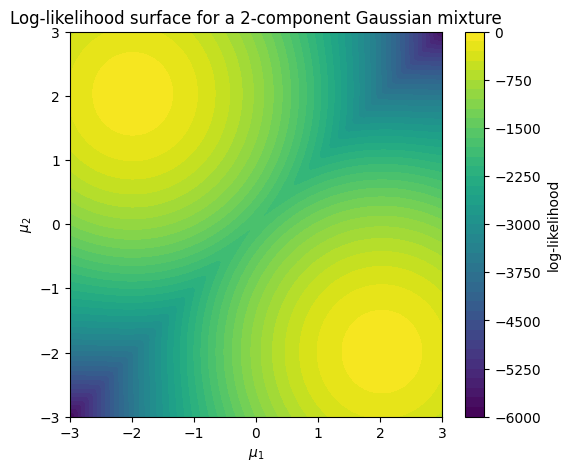

In [ ]:
data = np.concatenate([
    np.random.normal(-2, 0.3, 40),
    np.random.normal( 2, 0.3, 40)
])

def log_likelihood(mu1, mu2, sigma=0.3, pi=0.5):
  # Mixture likelihood for each data point
  pdf_vals = pi * norm.pdf(data, mu1, sigma) + (1 - pi) * norm.pdf(data, mu2, sigma)
  return np.sum(np.log(pdf_vals))

grid = np.linspace(-3, 3, 200)
LL = np.zeros((len(grid), len(grid)))

# Compute the log-likelihood
for i, mu1 in enumerate(grid):
  for j, mu2 in enumerate(grid):
    LL[i, j] = log_likelihood(mu1, mu2)

# Plot
plt.figure(figsize=(6,5))
plt.contourf(grid, grid, LL, levels=50, cmap="viridis")
plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")
plt.title("Log-likelihood surface for a 2-component Gaussian mixture")
plt.colorbar(label="log-likelihood")
plt.show()

⚠️ Dans les exemples que nous avons illustrés tant que maintenant, déterminer le maximum de la (log-)vraisemblance revient à déterminer la valeur de paramètre pour laquelle la dérivée de cette fonction est nulle. C'est ce que vous feriez si vous n'aviez pas accès à une méthode de résolution numérique comme c'est le cas ici, par exemple durant votre examen 😉 Ceci n'a évidemment du sens que parce que les fonctions de (log-)vraisemblance étudiées sont concaves.

Voyons ensemble un cas pour lequel cette méthode naïve ne fonctionnerait pas. Considérons le modèle exponentiel _décalé_ par un paramètre $\alpha$, tel que
$$f(y; \lambda, \alpha) = \lambda e^{\lambda(y - \alpha)}, \; \lambda > 0, \:\alpha \leq y,$$ et fixons le paramètre $\lambda$, de sorte que l'on cherche à estimer le MLE $\hat{\alpha}_{\mathrm{MLE}}$.

Le terme dépendant de $\alpha$ dans la log-vraisemblance se réduit à $$\lambda\sum_{i=1}^n\alpha$$ de sorte que la dérivée première est égale à $n\lambda$ et est donc strictement positive (pour $n>0$). Dans ce cas, l'estimateur du maximum de vraisemblance ne peut donc pas s'obtenir en annulant cette fonction, mais voyons plutôt à quoi cela ressemble 👀

In [ ]:
# Get the list of numerical columns from the dataframe (excl. 'longitude')
numerical_cols_filtered = [col for col in df.select_dtypes(include=np.number).columns.tolist() if col != 'longitude']


def log_likelihood_exponential_loc(loc, data, scale):
  """Log-likelihood for Exponential(loc, scale) with fixed scale, as a function of loc."""
  # The data must be >= loc for the likelihood to be non-zero
  if np.min(data) < loc:
      return -np.inf
  n = len(data)
  return -n * np.log(scale) - (1/scale) * (np.sum(data) - n * loc)

# Widgets
variable_dropdown_monotonic = widgets.Dropdown(
  options=numerical_cols_filtered,
  description='Variable:',
  disabled=False,
)

output_widget_monotonic = Output()

# Update function
def update_monotonic_plot(change):
  with output_widget_monotonic:
    clear_output(wait=True)

    selected_variable = variable_dropdown_monotonic.value

    data = df[selected_variable].dropna()
    if len(data) == 0:
        print("Selected variable has no data.")
        return

    # Use the largest sample size possible (all data)
    sample_data = data.copy()
    n = len(sample_data)

    # Fix the scale using the MLE (considering loc=0)
    min_data_full = df[selected_variable].dropna().min()
    shift = 0
    if min_data_full < 0:
      shift = -min_data_full
      # Shift the full data to estimate the scale
      full_data_shifted = df[selected_variable].dropna() + shift
      fixed_scale = np.mean(full_data_shifted) # MLE scale for Exponential with loc=0 is mean
    else:
      fixed_scale = np.mean(data)


    # Shift the sample data for plotting and MLE
    sample_data_shifted = sample_data + shift

    # The MLE for 'loc' is the minimum value in the sample data (on the shifted data)
    mle_loc_shifted = np.min(sample_data_shifted)
    mle_loc = mle_loc_shifted - shift # Convert back to original scale


    # Generate values for plotting log-likelihood of 'loc'
    loc_range_shifted = np.linspace(np.min(sample_data_shifted) - np.std(sample_data_shifted) * 0.5, np.min(sample_data_shifted) * 1.05, 100)
    loc_range_shifted = loc_range_shifted[loc_range_shifted <= np.min(sample_data_shifted)] # Ensure loc <= min(data)

    log_likelihood_values = [log_likelihood_exponential_loc(loc, sample_data_shifted, fixed_scale) for loc in loc_range_shifted]


    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram and Estimated PDF
    axes[0].hist(sample_data, bins='auto', density=True, alpha=0.6, label=f'Data Histogram (n={n})')
    x_data = np.linspace(sample_data.min(), sample_data.max(), 100)
    x_data = x_data[x_data >= mle_loc]
    axes[0].plot(x_data, expon.pdf(x_data, loc=mle_loc, scale=fixed_scale), 'r-', label=f'Exponential(loc={mle_loc:.2f}, scale={fixed_scale:.2f}) (MLE Fit)')
    axes[0].set_title(f'Histogram and MLE Fit for {selected_variable}')
    axes[0].set_xlabel(selected_variable)
    axes[0].set_ylabel('Density')
    axes[0].legend()
    axes[0].grid(True)

    # Log-Likelihood Function and MLE Estimate
    # Convert loc_range_shifted back to original scale for plotting
    loc_range = loc_range_shifted - shift
    axes[1].plot(loc_range, log_likelihood_values, label=fr'Log-Likelihood vs $\alpha$ (fixed scale={fixed_scale:.2f})')
    axes[1].axvline(mle_loc, color='r', linestyle='dashed', linewidth=1, label=fr'MLE $\hat{{\alpha}}$={mle_loc:.4f}')
    mle_loc_index = np.argmin(np.abs(loc_range - mle_loc))
    axes[1].plot(loc_range[mle_loc_index], log_likelihood_exponential_loc(mle_loc_shifted, sample_data_shifted, fixed_scale), 'ro') # Highlight max
    axes[1].set_xlabel(r'$\alpha$')
    axes[1].set_ylabel('Log-Likelihood')
    axes[1].set_title(f'Log-Likelihood for Exponential distribution (fixed scale)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Display estimated parameters
    print("Estimated Parameter (MLE):")
    print(fr"  $\alpha$: {mle_loc:.4f}")
    print(f"Fixed Parameter scale: {fixed_scale:.4f}")
    if shift > 0:
      print(f"Shift applied to data: {shift:.4f}")


# Widget-update link
variable_dropdown_monotonic.observe(update_monotonic_plot, names='value')

# Display all widgets
display(VBox([HBox([variable_dropdown_monotonic]), output_widget_monotonic]))

# Initial plot
update_monotonic_plot(None)

Rien de bien compliqué, mais gardez en tête que la méthode du MLE détermine la valeur de paramètre qui maximise la fonction de vraisemblance, pas celle qui annule sa dérivée première. 😉


Jusqu'à présent, à l'exception de la mixture de Normales, nous nous sommes pour nos visualisations limités à un seul paramètre estimé selon la méthode MLE pour chacun de nos modèles. Maintenant que le principe de cette méthode est bien compris, visualisons ensemble la fonction de log-vraisemblance complète et l'estimateur associé dans le cas de deux paramètres. 👀

In [ ]:
# Get the list of numerical columns from the dataframe
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Define the distributions and their log-likelihood functions
distributions_mle_2params = {
  'Normal': {
    'params': ['mu', 'sigma'],
    'log_likelihood': lambda params, data: -np.sum(norm.logpdf(data, loc=params[0], scale=params[1])),
    'pdf': lambda x, params: norm.pdf(x, loc=params[0], scale=params[1])
    },
  'Gamma': {
    'params': ['alpha', 'beta'], # Using alpha (shape) and beta (rate)
    'log_likelihood': lambda params, data: -np.sum(gamma.logpdf(data, a=params[0], scale=1/params[1])),
    'pdf': lambda x, params, loc: gamma.pdf(x, a=params[0], scale=1/params[1], loc=loc)
  }
}

# Widgets
distribution_dropdown_mle_2params = widgets.Dropdown(
  options=distributions_mle_2params.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal',
)

variable_dropdown_mle_2params = widgets.Dropdown(
  options=numerical_cols,
  description='Variable:',
  disabled=False,
  value=numerical_cols[0],
)

sample_size_slider = widgets.IntSlider(
  value=100,
  min=100,
  max=len(df),
  step=10,
  description='Sample size:',
  continuous_update=False,
)

output_widget_mle_2params = Output()

# Update function
def update_mle_2params_plot(change):
  with output_widget_mle_2params:
    clear_output(wait=True)

    selected_distribution_name = distribution_dropdown_mle_2params.value
    selected_variable = variable_dropdown_mle_2params.value

    data = df[selected_variable].dropna()

    # Sample
    sample_size = sample_size_slider.value
    if len(data) > sample_size:
      data = data.sample(sample_size, replace=False)

    if len(data) == 0:
      print("Selected variable has no data.")
      return

    # Get distribution, likelihood, and pdf
    selected_distribution = distributions_mle_2params[selected_distribution_name]
    log_likelihood_func = selected_distribution['log_likelihood']
    pdf_func = selected_distribution['pdf']
    params_names = selected_distribution['params']

    # Shift the data for non-negative distributions (Gamma)
    shift = 0
    if selected_distribution_name == 'Gamma' and np.min(data) < 0:
      shift = -np.min(data)
      # Add a small buffer to the shift
      shift *= 1.1
      data_shifted = data + shift
    else:
      data_shifted = data

    # Compute the MLE
    estimated_params = {}
    mle_results = None

    if selected_distribution_name == 'Normal':
      # Initial guess for mu (mean) and sigma (std deviation)
      initial_guess = [np.mean(data_shifted), np.std(data_shifted)]
      # Ensure standard deviation is positive
      initial_guess[1] = max(initial_guess[1], 1e-6)
      # Constraints: sigma > 0
      bounds = [(None, None), (1e-6, None)]
      mle_results = minimize(log_likelihood_func, initial_guess, args=(data_shifted,), bounds=bounds)
      estimated_params['mu'] = mle_results.x[0]
      estimated_params['sigma'] = mle_results.x[1]

      # Generate values for plotting log-likelihood heatmap and 3D plot
      mu_range = np.linspace(estimated_params['mu'] - 3. * estimated_params['sigma'], estimated_params['mu'] + 3. * estimated_params['sigma'], 50)
      sigma_range = np.linspace(1.5, estimated_params['sigma'] +50, 50)
      log_likelihood_values = np.zeros((len(sigma_range), len(mu_range)))
      for i, sigma in enumerate(sigma_range):
        for j, mu in enumerate(mu_range):
          try:
            log_likelihood_values[i, j] = -log_likelihood_func([mu, sigma], data_shifted)
          except:
            log_likelihood_values[i, j] = np.nan # Handle cases where parameters are invalid
      MU, SIGMA = np.meshgrid(mu_range, sigma_range)


    elif selected_distribution_name == 'Gamma':
      # Initial guess for alpha and beta (shape and rate) using method of moments
      mean = np.mean(data_shifted)
      variance = np.var(data_shifted)
      if mean > 0 and variance > 0:
        alpha_init = mean**2 / variance
        beta_init = mean / variance # rate parameter (1/scale)
        initial_guess = [max(alpha_init, 1e-6), max(beta_init, 1e-6)]
      else:
            initial_guess = [1.0, 1.0] # (Fallback) initial guess

      # Constraints: alpha > 0, beta > 0
      bounds = [(1e-6, None), (1e-6, None)]
      mle_results = minimize(log_likelihood_func, initial_guess, args=(data_shifted,), bounds=bounds)
      estimated_params['alpha'] = mle_results.x[0]
      estimated_params['beta'] = mle_results.x[1] # estimated rate

      # Generate values for plotting log-likelihood heatmap and 3D plot
      alpha_range = np.linspace(max(1e-6, estimated_params['alpha'] * 0.1), estimated_params['alpha'] * 2.0, 50)
      beta_range = np.linspace(max(1e-6, estimated_params['beta'] * 0.1), estimated_params['beta'] * 2.0, 50)
      log_likelihood_values = np.zeros((len(beta_range), len(alpha_range)))
      for i, beta_val in enumerate(beta_range):
        for j, alpha_val in enumerate(alpha_range):
          try:
            log_likelihood_values[i, j] = -log_likelihood_func([alpha_val, beta_val], data_shifted)
          except:
            log_likelihood_values[i, j] = np.nan # Handle cases where parameters are invalid
      ALPHA, BETA = np.meshgrid(alpha_range, beta_range)


    # Plot
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')


    # Histogram and Estimated PDF
    ax1.hist(data, bins='auto', density=True, alpha=0.6, label='Data Histogram')
    x_data = np.linspace(data.min(), data.max(), 100)

    if selected_distribution_name == 'Normal':
          ax1.plot(x_data, pdf_func(x_data, list(estimated_params.values())), 'r-', label=f'{selected_distribution_name} (MLE Fit)')
    elif selected_distribution_name == 'Gamma':
          # Ensure gamma pdf is only plotted for x >= -shift
          x_gamma = np.linspace(data.min(), data.max(), 100) # Use original data min for plotting range
          ax1.plot(x_gamma, pdf_func(x_gamma, list(estimated_params.values()), loc=-shift), 'r-', label=f'{selected_distribution_name} (MLE Fit)')

    ax1.set_title(f'Histogram and MLE Fit for {selected_variable}')
    ax1.set_xlabel(selected_variable)
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True)

    # Log-Likelihood Heatmap and MLE Estimate
    if np.nanmin(log_likelihood_values) > 0:
        norm = mcolors.LogNorm(vmin=np.nanmin(log_likelihood_values), vmax=np.nanmax(log_likelihood_values))
    else:
        norm = None

    if selected_distribution_name == 'Normal':
        im = ax2.imshow(log_likelihood_values, origin='lower', aspect='auto',
                        extent=[mu_range.min(), mu_range.max(), sigma_range.min(), sigma_range.max()],
                        cmap='viridis', norm=norm)
        ax2.scatter(estimated_params['mu'], estimated_params['sigma'], color='red', s=100, label='MLE')
        ax2.axvline(estimated_params['mu'], color='red', linestyle='dashed', linewidth=1)
        ax2.axhline(estimated_params['sigma'], color='red', linestyle='dashed', linewidth=1)
        ax2.set_xlabel(r'$\mu$')
        ax2.set_ylabel(r'$\sigma$')
        ax2.set_title(f'Log-Likelihood Heatmap for {selected_distribution_name}')
        plt.colorbar(im, ax=ax2, label='Log-Likelihood')

    elif selected_distribution_name == 'Gamma':
        im = ax2.imshow(log_likelihood_values, origin='lower', aspect='auto',
                        extent=[alpha_range.min(), alpha_range.max(), beta_range.min(), beta_range.max()],
                        cmap='viridis', norm=norm)
        ax2.scatter(estimated_params['alpha'], estimated_params['beta'], color='red', s=100, label='MLE')
        ax2.axvline(estimated_params['alpha'], color='red', linestyle='dashed', linewidth=1)
        ax2.axhline(estimated_params['beta'], color='red', linestyle='dashed', linewidth=1)
        ax2.set_xlabel(r'$\alpha$ (Shape)')
        ax2.set_ylabel(r'$\beta$ (Rate)')
        ax2.set_title(f'Log-Likelihood Heatmap for {selected_distribution_name}')
        plt.colorbar(im, ax=ax2, label='Log-Likelihood')

    ax2.legend()
    ax2.grid(True)

    # 3D Log-Likelihood Surface Plot and MLE Estimate
    if selected_distribution_name == 'Normal':
        ax3.plot_surface(MU, SIGMA, log_likelihood_values, cmap='viridis', alpha=0.8)

        mu_plane = np.full_like(SIGMA, estimated_params['mu'])
        sigma_plane = np.full_like(MU, estimated_params['sigma'])

        z_min = np.nanmin(log_likelihood_values) - 0.1*np.abs(np.nanmin(log_likelihood_values))
        z_max = np.nanmax(log_likelihood_values) + 0.1*np.abs(np.nanmax(log_likelihood_values))

        z_plane = np.expand_dims(np.linspace(z_min, z_max, 50), axis=0)
        ax3.plot_surface(mu_plane, SIGMA, z_plane, color='r', alpha=0.2)

        z_plane = np.expand_dims(np.linspace(z_min, z_max, 50), axis=1)
        ax3.plot_surface(MU, sigma_plane, z_plane, color='r', alpha=0.2)

        ax3.plot([estimated_params['mu']], [estimated_params['sigma']], [z_min, z_max], color='red', linewidth=2)

        ax3.set_xlabel(r'$\mu$')
        ax3.set_ylabel(r'$\sigma$')
        ax3.set_zlabel('Log-Likelihood')
        ax3.set_title(f'3D Log-Likelihood Surface for {selected_distribution_name}')

    elif selected_distribution_name == 'Gamma':
        ax3.plot_surface(ALPHA, BETA, log_likelihood_values, cmap='viridis', alpha=0.8)

        alpha_plane = np.full_like(BETA, estimated_params['alpha'])
        beta_plane = np.full_like(ALPHA, estimated_params['beta'])

        z_min = np.nanmin(log_likelihood_values) - 0.1*np.abs(np.nanmin(log_likelihood_values))
        z_max = np.nanmax(log_likelihood_values) + 0.1*np.abs(np.nanmax(log_likelihood_values))

        z_plane = np.expand_dims(np.linspace(z_min, z_max, 50), axis=0)
        ax3.plot_surface(alpha_plane, BETA, z_plane, color='r', alpha=0.2)

        z_plane = np.expand_dims(np.linspace(z_min, z_max, 50), axis=1)
        ax3.plot_surface(ALPHA, beta_plane, z_plane, color='r', alpha=0.2)

        ax3.plot([estimated_params['alpha']], [estimated_params['beta']], [z_min, z_max], color='red', linewidth=2)

        ax3.set_xlabel(r'$\alpha$ (Shape)')
        ax3.set_ylabel(r'$\beta$ (Rate)')
        ax3.set_zlabel('Log-Likelihood')
        ax3.set_title(f'3D Log-Likelihood Surface for {selected_distribution_name}')

    plt.tight_layout()
    plt.show()

    # Display estimated parameters
    print("Estimated Parameters (MLE):")
    for param, value in estimated_params.items():
        print(f"  {param}: {value:.4f}")
    if shift != 0:
        print(f"Shift applied to data: {shift:.4f}")


# Widget-update link
distribution_dropdown_mle_2params.observe(update_mle_2params_plot, names='value')
variable_dropdown_mle_2params.observe(update_mle_2params_plot, names='value')
sample_size_slider.observe(update_mle_2params_plot, names='value')

# Display all widgets
display(VBox([
  HBox([distribution_dropdown_mle_2params, variable_dropdown_mle_2params]),
  sample_size_slider,
  output_widget_mle_2params
]))

# Initial plot
update_mle_2params_plot(None)


❓Identifiez-vous une ou des directions selon laquelle ou lesquelles la fonction de log-vraisemblance est "plate" ? En particulier, que devient la courbure de la fonction selon le paramètre $\mu$, pour $\sigma$ qui augmente ? Pourquoi ?

❓La taille d'échantillon a-t-elle une influence sur la fonction de log-vraisemblance ?

> 🧠 Écrivez ici ce que vous en pensez !

## Propriétés du MLE

Bien, maintenant que la notion de maximum de vraisemblance est maîtrisée, et que vous avez une bonne compréhension de la méthode, nous allons revenir à des considérations un peu plus théoriques pour explorer les nombreuses **propriétés de l'estimateur MLE**.

>Tout d'abord, intéressons nous à un résultat très important qui *motive* l'utilisation de cet estimateur. 💪

Ce résultat est le suivant : si l'on suppose que nos données sont générées par la CDF jointe $F_{\mathbf{Y}}(\mathbf{y} ; \theta^*)$ avec $\theta^*$ la "vraie" valeur du paramètre que l'on cherche à estimer, et bien $\theta^*$ correspond à la valeur qui maximise l'espérance de la fonction de log-vraisemblance, où l'espérance est calculée par rapport aux données $\mathbf{y}$. Autrement dit, si on calculait la fonction de log-vraisemblance pour tous les échantillons $\mathbf{y}$ possibles, et que l'on calculait la moyenne sur ces différents échantillons, la valeur du paramètre $\theta$ qui maximise cette fonction moyenne correspondrait à la "vraie" valeur de $\theta$ !

L'utilisation du MLE exploite donc le fait que la (log-)vraisemblance *observée* (_i.e._ pour un échantillon $\mathbf{y}$) aura tendance à avoir son maximum pour une valeur de $\theta$ proche de $\theta^*$.

Définissons un processus générateur $F_{\mathbf{Y}}(\mathbf{y} ; \theta^*)$ et voyons ensemble ce résultat avec des données synthétiques : observons comment se ditribuent les MLEs pour les différents échantillons, et à quoi correspond le maximum de la fonction de log-vraisemblance moyenne. 👀

In [ ]:
# Define the distributions and their log-likelihood functions and true parameters
distributions_expected_ll = {
  'Normal': {
    'params': ['mu', 'sigma'],
    'true_params': {'mu': 0, 'sigma': 1},
    'log_likelihood': lambda params, data: np.sum(norm.logpdf(data, loc=params[0], scale=params[1])),
    'param_range': lambda true_params: np.linspace(true_params['mu'] - 3 * true_params['sigma'], true_params['mu'] + 3 * true_params['sigma'], 500), # Range for mu
    'fixed_param_name': 'sigma',
    'fixed_param_value': 1
  },
  'Exponential': {
    'params': ['lambda'],
    'true_params': {'lambda': 0.5},
    'log_likelihood': lambda params, data: np.sum(expon.logpdf(data, scale=1/params[0])), # params[0] is lambda
    'param_range': lambda true_params: np.linspace(max(1e-6, true_params['lambda'] * 0.1), true_params['lambda'] * 5, 500), # Range for lambda
    'fixed_param_name': None, # No fixed parameter for Exponential (single parameter)
    'fixed_param_value': None
  },
  'Gamma': {
    'params': ['alpha', 'beta'], # alpha (shape), beta (rate)
    'true_params': {'alpha': 2, 'beta': 1},
    'log_likelihood': lambda params, data: np.sum(gamma.logpdf(data, a=params[0], scale=1/params[1])), # params[0]=alpha, params[1]=beta, scale=1/beta
    'param_range': lambda true_params: np.linspace(max(1e-6, true_params['alpha'] * 0.1), true_params['alpha'] * 3, 500), # Range for alpha
    'fixed_param_name': 'beta',
    'fixed_param_value': 1
  }
}

# Widgets
distribution_dropdown_expected_ll = widgets.Dropdown(
  options=distributions_expected_ll.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal',
)

sample_size_slider_expected_ll = widgets.IntSlider(
  value=100,
  min=10,
  max=1000,
  step=10,
  description='Sample Size (n):',
  continuous_update=False,
  disabled=False,
)

num_samples_slider_expected_ll = widgets.IntSlider(
  value=100,
  min=10,
  max=1000,
  step=10,
  description='Number of Samples (m):',
  continuous_update=False,
  disabled=False,
)

noise_level_slider = widgets.FloatSlider(
  value=0.0,
  min=0.0,
  max=1.0,
  step=0.05,
  description='Noise Level:',
  continuous_update=False,
  disabled=False,
)


output_widget_expected_ll = Output()

def update_expected_ll_plot(change):
  with output_widget_expected_ll:
    clear_output(wait=True)

    selected_distribution_name = distribution_dropdown_expected_ll.value
    selected_sample_size = sample_size_slider_expected_ll.value
    selected_num_samples = num_samples_slider_expected_ll.value
    noise_level = noise_level_slider.value

    selected_distribution = distributions_expected_ll[selected_distribution_name]
    true_params = selected_distribution['true_params']
    log_likelihood_func = selected_distribution['log_likelihood']
    param_range_func = selected_distribution['param_range']
    fixed_param_name = selected_distribution['fixed_param_name']
    fixed_param_value = selected_distribution['fixed_param_value']

    # Determine the parameter to vary and its name
    varying_param_name = None
    if selected_distribution_name == 'Normal':
      varying_param_name = 'mu'
      true_value = true_params['mu']
      param_range = param_range_func(true_params)
    elif selected_distribution_name == 'Exponential':
      varying_param_name = 'lambda'
      true_value = true_params['lambda']
      param_range = param_range_func(true_params)
    elif selected_distribution_name == 'Gamma':
      varying_param_name = 'alpha' # Vary alpha, fix beta
      true_value = true_params['alpha']
      param_range = param_range_func(true_params)


    # Simulate multiple samples and compute log-likelihood and MLE for each
    all_log_likelihoods = []
    mle_estimates = []
    for _ in range(selected_num_samples):
      if selected_distribution_name == 'Normal':
        sample_data = np.random.normal(loc=true_params['mu'], scale=true_params['sigma'], size=selected_sample_size)
          # Perform MLE for the varying parameter (mu) with fixed sigma
        mle_results = minimize(lambda p, data, fixed_sigma: -log_likelihood_func([p[0], fixed_sigma], data), [np.mean(sample_data)], args=(sample_data, true_params['sigma']), bounds=[(None, None)])
        mle_estimates.append(mle_results.x[0])

      elif selected_distribution_name == 'Exponential':
        sample_data = np.random.exponential(scale=1/true_params['lambda'], size=selected_sample_size) # scale = 1/lambda
        # Perform MLE for lambda
        mle_results = minimize(lambda p, data: -log_likelihood_func([p[0]], data), [1/np.mean(sample_data)] if np.mean(sample_data) > 0 else [1.0], args=(sample_data,), bounds=[(1e-6, None)])
        mle_estimates.append(mle_results.x[0])

      elif selected_distribution_name == 'Gamma':
        sample_data = np.random.gamma(shape=true_params['alpha'], scale=1/true_params['beta'], size=selected_sample_size) # scale = 1/beta
        # Perform MLE for alpha with fixed beta
        mle_results = minimize(lambda p, data, fixed_beta: -log_likelihood_func([p[0], fixed_beta], data), [np.mean(sample_data)**2/np.var(sample_data)] if np.mean(sample_data) > 0 and np.var(sample_data) > 0 else [1.0], args=(sample_data, true_params['beta']), bounds=[(1e-6, None)])
        mle_estimates.append(mle_results.x[0])


      # Add noise
      noise = np.random.normal(loc=0, scale=noise_level * np.std(sample_data), size=selected_sample_size)
      sample_data_noisy = sample_data + noise

      if selected_distribution_name == 'Normal':
        log_likelihood_values = [log_likelihood_func([p, true_params['sigma']], sample_data_noisy) for p in param_range]
      elif selected_distribution_name == 'Exponential':
        log_likelihood_values = [log_likelihood_func([p], sample_data_noisy) for p in param_range]
      elif selected_distribution_name == 'Gamma':
        log_likelihood_values = [log_likelihood_func([p, true_params['beta']], sample_data_noisy) for p in param_range]


      all_log_likelihoods.append(log_likelihood_values)

    # Calculate the mean log-likelihood across all samples
    mean_log_likelihood = np.mean(all_log_likelihoods, axis=0)

    # Find the parameter value that maximizes the mean log-likelihood (should be the expected MLE)
    mle_mean_ll = param_range[np.argmax(mean_log_likelihood)]

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [1, 3]}) # Add a new subplot on top


    # KDE of MLE estimates
    if len(mle_estimates) > 1:
      try:
        kde = gaussian_kde(mle_estimates)
        x_kde = np.linspace(min(mle_estimates) - np.std(mle_estimates), max(mle_estimates) + np.std(mle_estimates), 200)
        axes[0].plot(x_kde, kde(x_kde), color='purple', label='KDE of MLE Estimates')
        axes[0].fill_between(x_kde, kde(x_kde), color='purple', alpha=0.2)
        axes[0].axvline(true_value, color='green', linestyle='dashed', linewidth=1, label=f'True {varying_param_name}={true_value}')
        axes[0].set_ylabel('Density')
        axes[0].set_title(f'Distribution of $\\hat{{\\theta}}_{{{varying_param_name}}}$ (MLE) (n={selected_sample_size}, m={selected_num_samples})')
        axes[0].legend()
        axes[0].grid(True)
      except np.linalg.LinAlgError:
        axes[0].text(0.5, 0.5, 'KDE estimation failed (insufficient data variability)', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
        axes[0].set_title(f'Distribution of $\\hat{{\\theta}}_{{{varying_param_name}}}$ (MLE) (n={selected_sample_size}, m={selected_num_samples})')
        axes[0].grid(True)
    else:
      axes[0].text(0.5, 0.5, 'Not enough MLE estimates to compute KDE', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
      axes[0].set_title(f'Distribution of $\\hat{{\\theta}}_{{{varying_param_name}}}$ (MLE) (n={selected_sample_size}, m={selected_num_samples})')
      axes[0].grid(True)


    # Log-Likelihoods
    for ll_values in all_log_likelihoods:
      axes[1].plot(param_range, ll_values, color='skyblue', alpha=0.1)

    # Plot the mean log-likelihood
    axes[1].plot(param_range, mean_log_likelihood, color='blue', linewidth=2, label='Mean Log-Likelihood')

    # Highlight the maximum of the mean log-likelihood
    axes[1].plot(mle_mean_ll, np.max(mean_log_likelihood), 'ro', markersize=8)
    axes[1].axvline(mle_mean_ll, color='red', linestyle='dashed', linewidth=1, label=f'Max Mean LL at $\\hat{{{varying_param_name}}}$={mle_mean_ll:.4f}')

    # Add vertical line at the true parameter value
    axes[1].axvline(true_value, color='green', linestyle='dashed', linewidth=1, label=f'True {varying_param_name}={true_value}')
    axes[1].set_xlabel(f'Parameter value ({varying_param_name})')
    axes[1].set_ylabel('Log-Likelihood')
    axes[1].legend()
    axes[1].grid(True)


    plt.tight_layout()
    plt.show()


# Widget-update link
distribution_dropdown_expected_ll.observe(update_expected_ll_plot, names='value')
sample_size_slider_expected_ll.observe(update_expected_ll_plot, names='value')
num_samples_slider_expected_ll.observe(update_expected_ll_plot, names='value')
noise_level_slider.observe(update_expected_ll_plot, names='value')

# Display all widgets
display(VBox([HBox([distribution_dropdown_expected_ll, sample_size_slider_expected_ll, num_samples_slider_expected_ll, noise_level_slider]), output_widget_expected_ll]))

# Initial plot
update_expected_ll_plot(None)

❓À quoi correspond la "KDE" utilisée dans la visualisation ci-dessus ? À quoi sert-elle ? Comment fonctionne-t-elle ? Y a-t-il un choix à faire pour certains paramètres ? Quelle influence ont-ils ?

❓Qu'observez-vous ? L'expérience rejoint-elle la théorie ? Expliquez.

❓Quelle influence la taille d'échantillon a-t-elle ? Expliquez.

❓Quelle influence le nombre d'échantillons considéré a-t-il ? Expliquez.

> 🧠 Écrivez ici ce que vous en pensez !

Bien, la méthode du maximum de vraisemblance étant motivée, nous allons pouvoir nous intéresser aux propriétés intéressantes que l'estimateur possède. Pour cela, rappelons rapidement quelques concepts et notations importantes.

>La dérivée première de la fonction de log-vraisemblance par rapport au paramètre $\theta$ est appelée fonction score $$s(\theta; \mathbf{y}) = \frac{∂\:\log L(\theta; \mathbf{y} ) }{∂\theta}.$$

Pour $\theta=\theta^*$, et sous certaines conditions de régularité, on a
$$E(s(\theta^*; \mathbf{Y})) = 0$$
c'est-à-dire que la dérivée de la fonction de log-vraisemblance est nulle en moyenne sur différents échantillons, et
$$\mathrm{Var}(s(\theta^*; \mathbf{Y})) = -E(s'(\theta^*; \mathbf{Y})),$$
où $s'$ dénote la dérivée du score par rapport à $\theta$, c'est-à-dire que la variance de la fonction score est égale à l'opposé de l'espérance de sa dérivée (cette relation porte le nom d'_égalité de l'information_).
> Cette variance de la fonction score en $\theta=\theta^*$ est également appelée information de Fisher, notée $\mathcal{I}_{\mathbf{Y}}(\theta)$. Elle représente une mesure de l'information qu'apportent les données $\mathbf{Y}$ à propos du paramètre à estimer $\theta$.

Visualisons cela ensemble à partir de données synthétiques ;  attention, la génération des figures peut prendre quelques minutes (prenez bien le temps de comparer les différents éléments présents sur les graphes avec les relations théoriques que l'on vient de rappeler !) 👀

In [ ]:
# Define the distributions and their log-likelihood functions and true parameters
distributions_expected_ll = {
  'Normal (fixed sigma)': {
    'params': ['mu', 'sigma'],
    'true_params': {'mu': 0, 'sigma': 1},
    'log_likelihood': lambda params, data: np.sum(norm.logpdf(data, loc=params[0], scale=params[1])),
    'score_function': lambda params, data: np.sum((data - params[0]) / params[1]**2), # Derivative of log-likelihood w.r.t mu
    'fisher_info': lambda params, n: n / params[1]**2, # Fisher Information for mu (for a fixed sigma)
    'param_range': lambda true_params: np.linspace(true_params['mu'] - 3 * true_params['sigma'], true_params['mu'] + 3 * true_params['sigma'], 101), # Range for mu
    'fixed_param_name': 'sigma',
    'fixed_param_value': 1
  },
  'Normal (fixed mu)': {
    'params': ['mu', 'sigma'],
    'true_params': {'mu': 0, 'sigma': 1},
    'log_likelihood': lambda params, data: np.sum(norm.logpdf(data, loc=params[0], scale=params[1])),
    'score_function': lambda params, data: np.sum((data - params[0])**2 / params[1]**3 - 1 / params[1]), # Derivative of log-likelihood w.r.t sigma
    'fisher_info': lambda params, n: 2 * n / params[1]**2, # Fisher Information for sigma (for a fixed mu)
    'param_range': lambda true_params: np.linspace(true_params['sigma'] * .5, true_params['sigma'] * 1.5, 101), # Range for sigma (ensure positive)
    'fixed_param_name': 'mu',
    'fixed_param_value': 0
  },
  'Exponential': {
    'params': ['lambda'],
    'true_params': {'lambda': 0.5},
    'log_likelihood': lambda params, data: np.sum(expon.logpdf(data, scale=1/params[0])), # params[0] is lambda
    'score_function': lambda params, data: np.sum(1/params[0] - data), # Derivative of log-likelihood w.r.t lambda
    'fisher_info': lambda params, n: n / params[0]**2, # Fisher Information for lambda
    'param_range': lambda true_params: np.linspace(max(1e-6, true_params['lambda'] * .5), true_params['lambda'] * 1.5, 100), # Range for lambda
    'fixed_param_name': None, # No fixed parameter for Exponential (single parameter)
    'fixed_param_value': None
  },
}

# Widgets
distribution_dropdown_expected_ll = widgets.Dropdown(
  options=distributions_expected_ll.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal (fixed sigma)',
)

sample_size_slider_expected_ll = widgets.IntSlider(
  value=30,
  min=10,
  max=1000,
  step=10,
  description='Sample Size (n):',
  continuous_update=False,
  disabled=False,
)

num_samples_slider_expected_ll = widgets.IntSlider(
  value=10000,
  min=100,
  max=100000,
  step=10,
  description='Number of Samples (m):',
  continuous_update=False,
  disabled=False,
)

noise_level_slider = widgets.FloatSlider(
  value=0.0,
  min=0.0,
  max=1.0,
  step=0.05,
  description='Noise Level:',
  continuous_update=False,
  disabled=False,
)


output_widget_expected_ll = Output()

# Update function
def update_expected_ll_plot(change):
  with output_widget_expected_ll:
    clear_output(wait=True)
    selected_distribution_name = distribution_dropdown_expected_ll.value
    selected_sample_size = sample_size_slider_expected_ll.value
    selected_num_samples = num_samples_slider_expected_ll.value
    noise_level = noise_level_slider.value

    selected_distribution = distributions_expected_ll[selected_distribution_name]
    true_params = selected_distribution['true_params']
    log_likelihood_func = selected_distribution['log_likelihood']
    score_function_func = selected_distribution.get('score_function') # Get score function if available
    fisher_info_func = selected_distribution.get('fisher_info') # Get Fisher Info if available
    param_range_func = selected_distribution['param_range']
    fixed_param_name = selected_distribution['fixed_param_name']
    fixed_param_value = selected_distribution['fixed_param_value']

    # Determine the parameter to vary and its name
    varying_param_name = None
    if selected_distribution_name == 'Normal (fixed sigma)':
      varying_param_name = 'mu'
      true_value = true_params['mu']
      param_range = param_range_func(true_params)
    elif selected_distribution_name == 'Normal (fixed mu)':
      varying_param_name = 'sigma'
      true_value = true_params['sigma']
      param_range = param_range_func(true_params)
    elif selected_distribution_name == 'Exponential':
      varying_param_name = 'lambda'
      true_value = true_params['lambda']
      param_range = param_range_func(true_params)
    elif selected_distribution_name == 'Gamma':
      varying_param_name = 'alpha'
      true_value = true_params['alpha']
      param_range = param_range_func(true_params)

    # Simulate multiple samples and compute log-likelihood and score function for each
    all_log_likelihoods = []
    all_score_functions = []
    all_deriv_score_functions = []

    for _ in range(selected_num_samples):
      if selected_distribution_name in ['Normal (fixed sigma)', 'Normal (fixed mu)']:
        sample_data = np.random.normal(loc=true_params['mu'], scale=true_params['sigma'], size=selected_sample_size)
        if selected_distribution_name == 'Normal (fixed sigma)':
          log_likelihood_values = [log_likelihood_func([p, true_params['sigma']], sample_data) for p in param_range]
          if score_function_func:
            score_values = [score_function_func([p, true_params['sigma']], sample_data) for p in param_range]
            all_score_functions.append(score_values)
            # Derivative of score function w.r.t mu for Normal
            deriv_score_values = [-selected_sample_size / true_params['sigma']**2] * len(param_range)
            all_deriv_score_functions.append(deriv_score_values)
        elif selected_distribution_name == 'Normal (fixed mu)':
          log_likelihood_values = [log_likelihood_func([true_params['mu'], p], sample_data) for p in param_range]
          if score_function_func:
            score_values = [score_function_func([true_params['mu'], p], sample_data) for p in param_range]
            all_score_functions.append(score_values)
            # Derivative of score function w.r.t sigma for Normal
            deriv_score_values = [-3 * np.sum((sample_data - true_params['mu'])**2) / p**4 + selected_sample_size / p**2 for p in param_range]
            all_deriv_score_functions.append(deriv_score_values)


      elif selected_distribution_name == 'Exponential':
        sample_data = np.random.exponential(scale=1/true_params['lambda'], size=selected_sample_size) # scale = 1/lambda
        log_likelihood_values = [log_likelihood_func([p], sample_data) for p in param_range]
        if score_function_func:
          score_values = [score_function_func([p], sample_data) for p in param_range]
          all_score_functions.append(score_values)
          # Derivative of score function w.r.t lambda for Exponential
          deriv_score_values = [-selected_sample_size / p**2 for p in param_range]
          all_deriv_score_functions.append(deriv_score_values)

      all_log_likelihoods.append(log_likelihood_values)

    # Calculate the mean log-likelihood, mean score function, and mean derivative of score function across all samples
    mean_log_likelihood = np.mean(all_log_likelihoods, axis=0)
    mean_score_function = np.mean(all_score_functions, axis=0) if all_score_functions else None
    mean_deriv_score_function = np.mean(all_deriv_score_functions, axis=0) if all_deriv_score_functions else None


    # Find the parameter value that maximizes the mean log-likelihood
    mle_mean_ll = param_range[np.nanargmax(mean_log_likelihood)]


    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True) # 3 subplots stacked vertically

    # Log-Likelihoods
    for ll_values in all_log_likelihoods:
      axes[0].plot(param_range, ll_values, color='skyblue', alpha=0.1)
    axes[0].plot(param_range, mean_log_likelihood, color='blue', linewidth=2, label='Mean Log-Likelihood')
    axes[0].plot(mle_mean_ll, np.nanmax(mean_log_likelihood), 'ro', markersize=8)
    axes[0].axvline(mle_mean_ll, color='red', linestyle='dashed', linewidth=1, label=f'Max Mean LL at $\\hat{{{varying_param_name}}}$={mle_mean_ll:.4f}')
    axes[0].axvline(true_value, color='green', linestyle='dashed', linewidth=1, label=f'True {varying_param_name}={true_value}')
    axes[0].set_ylabel('Log-Likelihood')
    axes[0].legend()
    axes[0].grid(True)


    # Score Functions
    if mean_score_function is not None:
      # Find the parameter value where the mean score function is closest to zero (we cheat a bit here, and use this as a proxy for the true value of the parameter ;-)
      mle_score_idx = np.nanargmin(np.abs(mean_score_function))
      mle_score = param_range[mle_score_idx]
      mle_score_values = []

      for score_values in all_score_functions:
        axes[1].plot(param_range, score_values, color='salmon', alpha=0.1)
        mle_score_values.append(score_values[mle_score_idx])
      axes[1].plot(param_range, mean_score_function, color='red', linewidth=2, label='Mean Score Function')

      fisher_info_score_inv = np.var(mle_score_values, ddof=0)
      axes[1].plot(param_range, np.var(all_score_functions, axis=0), color='blue', linewidth=2, label='Fisher Information')

      axes[1].vlines(mle_score, np.mean(mle_score_values) - 3*np.sqrt(fisher_info_score_inv), np.mean(mle_score_values) + 3*np.sqrt(fisher_info_score_inv), color='purple', linewidth=1.5, label=f'Var(s) = {fisher_info_score_inv}')

      axes[1].axhline(0, color='grey', linestyle='dashed', linewidth=1)
      axes[1].axvline(true_value, color='green', linestyle='dashed', linewidth=1)
      axes[1].set_ylabel('Score Function')

      axes[1].legend()
      axes[1].grid(True)

    # Derivative of Score Functions
    if mean_deriv_score_function is not None:

      mle_score_deriv_values = []
      for deriv_score_values in all_deriv_score_functions:
        axes[2].plot(param_range, deriv_score_values, color='lightgreen', alpha=0.1)
        mle_score_deriv_values.append(deriv_score_values[mle_score_idx])
      axes[2].plot(param_range, mean_deriv_score_function, color='green', linewidth=2, label='Mean Derivative of Score Function')
      axes[2].axvline(true_value, color='green', linestyle='dashed', linewidth=1) # True value line
      axes[2].set_xlabel(f'Parameter value ({varying_param_name})')
      axes[2].set_ylabel('Derivative of Score Function')

      expected_score_deriv = np.mean(mle_score_deriv_values)
      axes[2].scatter(mle_score, expected_score_deriv, color='purple', marker='o', label=f"E(s') = {expected_score_deriv}")

      axes[2].legend()
      axes[2].grid(True)

    fig.tight_layout()
    plt.show()


# Widgets-update link
distribution_dropdown_expected_ll.observe(update_expected_ll_plot, names='value')
sample_size_slider_expected_ll.observe(update_expected_ll_plot, names='value')
num_samples_slider_expected_ll.observe(update_expected_ll_plot, names='value')
noise_level_slider.observe(update_expected_ll_plot, names='value')

# Display all widgets
display(VBox([HBox([distribution_dropdown_expected_ll, sample_size_slider_expected_ll, num_samples_slider_expected_ll, noise_level_slider]), output_widget_expected_ll]))

# Initial plot
update_expected_ll_plot(None)

❓À nouveau, l'expérience rejoint-elle la théorie ? Cela est-il le cas pour toutes les tailles d'échantillon et tous les nombres d'échantillons considérés ? Expliquez.

> 🧠 Écrivez ici ce que vous en pensez !

🧐 Attardons nous un bref moment sur le concept d'information de Fisher. Comme déjà dit, cette mesure rend compte de la quantité d'information qu'apportent les données à propos d'un estimand dans un modèle statistique paramétrique. De part sa définition, une grande information de Fisher correspond à une variance élevée (d'un échantillon à un autre) dans la pente de la fonction de log-vraisemblance en la "vraie" valeur de $\theta$. Par l'_égalité de l'information_, elle correspond également à (l'opposé de) l'espérance de la courbure de la fonction de log-vraisemblance.

Ainsi, cette seconde formulation rend plus intuitivement compte de la notion de mesure d'information: si, en moyenne, la courbure est faible en $\theta^*$, cela signifie que les données n'amènent pas beaucoup d'information pour identifier une bonne estimation de $\theta^*$. Autrement dit, les données ne contraignent que peu le choix de l'estimation. Si, au contraire, la courbure moyenne est élevée, les données amènent plus d'information et contraignent plus le choix de l'estimation.

Illustrons ça à l'aide d'un exemple simple : considérons $\mathbf{Y}_n$ un échantillon de taille $n$ avec $Y_1, \ldots, Y_n$ _i.i.d._ et $Y_i \sim \mathcal{N}(\mu, \sigma^2)\; \forall i \in \{1, \ldots, n\}$ avec $\sigma$ connu. Voyons ensemble comment évolue la courbure de la fonction de log-vraisemblance pour $\mu$ pour $n$ croissant. 👀

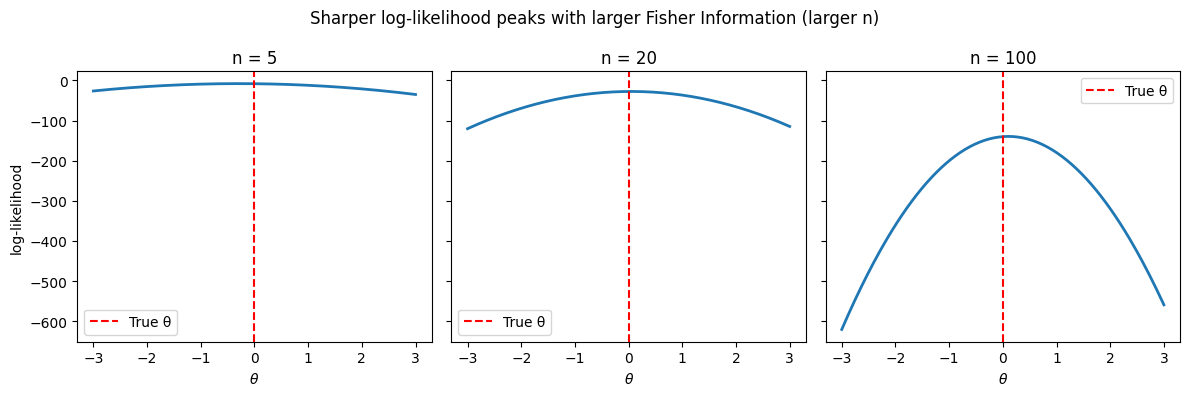

In [ ]:
# Parameters
theta_true = 0
sigma = 1

# Different sample sizes and thetas
sample_sizes = [5, 20, 100]
thetas = np.linspace(-3, 3, 200)

fig, axs = plt.subplots(1, len(sample_sizes), figsize=(12, 4), sharey=True)

# Plot
for i, n in enumerate(sample_sizes):
  # Simulate data
  x = np.random.normal(theta_true, sigma, n)

  # Compute log-likelihood for each candidate theta
  logL = [np.sum(norm.logpdf(x, loc=th, scale=sigma)) for th in thetas]

  axs[i].plot(thetas, logL, lw=2)
  axs[i].axvline(theta_true, color='red', ls='--', label='True θ')
  axs[i].set_title(f'n = {n}')
  axs[i].set_xlabel(r'$\theta$')
  if i == 0:
    axs[i].set_ylabel('log-likelihood')
  axs[i].legend()

plt.suptitle("Sharper log-likelihood peaks with larger Fisher Information (larger n)")
plt.tight_layout()
plt.show()


❓Comment interprétez-vous le changement de courbure avec la taille $n$ d'échantillon ? Comment ceci est-il lié à la notion d'"information" ?

> 🧠 Écrivez ici ce que vous en pensez !

😎 Maintenant que ces notions sont rafraîchies, passons (enfin) aux propriétés du MLE !

Débutons avec les propriétés _asymptotiques_, c'est-à-dire pour la taille d'échantillon $n\rightarrow\infty$.

Le MLE est
- **_asymptotiquement_ Normal**, _i.e._ il se distribue approximativement de manière normale pour $n\rightarrow\infty$,
- **_asymptotiquement_ non-biaisé**, _i.e._ son biais approche zéro pour $n\rightarrow\infty$,
- **_asymptotiquement_ efficient**, _i.e._ aucun autre estimateur _asymptotiquement_ non-biaisé n'aura un écart-type plus faible pour $n\rightarrow\infty$.

Cette dernière propriété peut être liée à une borne théorique sur la variance d'un estimateur non-biaisé $\hat{\theta}$ d'un paramètre $\theta$ appelée _borne inférieure de Cramér-Rao_, dont l'abréviation est CRLB.

>Sous certaines conditions de régularité, cette borne est liée à l'information de Fisher et nous avons la condition $$Var(\hat{\theta}) \geq \frac{1}{\mathcal{I}_{\mathbf{Y}}(\theta)}$$ sur la variance de l'estimateur non-biaisé.

L'existence de cette borne implique qu'un **estimateur asymptotiquement non-biaisé** dont la **variance est égale à cette CRLB** possède donc la **variance la plus faible possible** pour un estimateur asymptotiquement non-biaisé, et est donc **asymptotiquement efficient**. Vous suivez toujours ? 😉

Visualisons ensemble ces trois premières propriétés. 👀

In [ ]:
# Define the distributions, their true parameters, log-likelihood, and Fisher Information
distributions_asymptotic = {
  'Normal (fixed sigma)': {
    'true_params': {'mu': 0, 'sigma': 1},
    'log_likelihood': lambda params, data: -np.sum(norm.logpdf(data, loc=params[0], scale=params[1])),
    'mle_estimator': lambda data, fixed_param: np.mean(data), # MLE for mu when sigma is fixed
    'fisher_info': lambda params, n: n / params[1]**2, # Fisher Information for mu
    'varying_param_name': 'mu',
    'fixed_param_name': 'sigma'
  },
  'Exponential': {
    'true_params': {'lambda': 0.5},
    'log_likelihood': lambda params, data: -np.sum(expon.logpdf(data, scale=1/params[0])), # params[0] is lambda
    'mle_estimator': lambda data, fixed_param: 1 / np.mean(data) if np.mean(data) > 0 else np.nan, # MLE for lambda
    'fisher_info': lambda params, n: n / params[0]**2, # Fisher Information for lambda
    'varying_param_name': 'lambda',
    'fixed_param_name': None
  },
}

# Widgets
distribution_dropdown_asymptotic = widgets.Dropdown(
  options=distributions_asymptotic.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal (fixed sigma)',
)

max_sample_size_slider = widgets.IntSlider(
  value=100,
  min=15,
  max=1000,
  step=10,
  description='Max Sample Size (N):',
  continuous_update=False,
  disabled=False,
)

num_mle_samples_slider = widgets.IntSlider(
  value=1000,
  min=100,
  max=5000,
  step=100,
  description='Number of MLEs (M):',
  continuous_update=False,
  disabled=False,
)

output_widget_asymptotic = Output()

# Update function
def update_asymptotic_plots(change):
  with output_widget_asymptotic:
    clear_output(wait=True)

    selected_distribution_name = distribution_dropdown_asymptotic.value
    max_sample_size = max_sample_size_slider.value
    num_mle_samples = num_mle_samples_slider.value

    selected_distribution = distributions_asymptotic[selected_distribution_name]
    true_params = selected_distribution['true_params']
    mle_estimator_func = selected_distribution['mle_estimator']
    fisher_info_func = selected_distribution['fisher_info']
    varying_param_name = selected_distribution['varying_param_name']
    fixed_param_name = selected_distribution['fixed_param_name']
    true_value = true_params[varying_param_name]

    # Simulate data and compute MLEs for varying sample sizes
    sample_sizes = np.arange(5, max_sample_size + 1)
    mle_estimates = {}

    for n in sample_sizes:
      mle_estimates[n] = []
      for _ in range(num_mle_samples):
        if selected_distribution_name == 'Normal (fixed sigma)':
          sample_data = np.random.normal(loc=true_params['mu'], scale=true_params['sigma'], size=n)
          mle = mle_estimator_func(sample_data, true_params['sigma'])
        elif selected_distribution_name == 'Exponential':
          sample_data = np.random.exponential(scale=1/true_params['lambda'], size=n)
          mle = mle_estimator_func(sample_data, None)

        mle_estimates[n].append(mle)

    # Calculate properties of MLE for each sample size
    mean_mles = np.array([np.nanmean(mle_estimates[n]) for n in sample_sizes])
    bias = mean_mles - true_value
    variance_mles = np.array([np.nanvar(mle_estimates[n]) for n in sample_sizes])
    std_error_mles = np.sqrt(variance_mles)
    lower_bound_variance = np.array([1 / fisher_info_func(list(true_params.values()), n) for n in sample_sizes]) # Cramer-Rao Lower Bound


    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Distribution of MLE for increasing n (using histograms)
    axes[0].set_title(f'Distribution of $\\hat{{\\theta}}_{{{varying_param_name}}}$ (MLE) for increasing sample size (n)')
    axes[0].set_ylabel('Density')
    axes[0].axhline(true_value, color='green', linestyle='dashed', linewidth=1, label=f'True {varying_param_name}={true_value}')
    axes[0].legend()
    axes[0].grid(True)

    bins = 30
    max_density = 0
    min_density = 1e6
    for i, n in enumerate(sample_sizes):
      if i != 0 and (i % (max_sample_size // 15) == 0): # Plot for a subset of n for clarity
        hist, bin_edges = np.histogram(mle_estimates[n], bins=bins, density=False)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axes[0].barh(y=bin_centers, width=hist / (5000 / max_sample_size), height=bin_edges[1]-bin_edges[0], left=n, alpha=0.75, color='skyblue')  # divide width by 2 for clarity
        max_density = np.max([max_density, np.max(bin_centers)])
        min_density = np.min([min_density, np.min(bin_centers)])

    axes[0].set_ylim([min_density - 1e-3, max_density + 1e-3])
    axes[0].set_xlim([0, max_sample_size + sample_sizes[max_sample_size // 20] ])


    # Bias of MLE
    axes[1].plot(sample_sizes, bias, label=f'Bias of $\\hat{{\\theta}}_{{{varying_param_name}}}$', color='blue')
    axes[1].plot(sample_sizes, 3 * std_error_mles, linestyle='dashed', color='red', label=f'$\\pm 3 \\times$ Std Error')
    axes[1].plot(sample_sizes, -3 * std_error_mles, linestyle='dashed', color='red')
    axes[1].axhline(0, color='grey', linestyle='dashed', linewidth=1)
    axes[1].set_ylabel('Bias')
    axes[1].legend()
    axes[1].grid(True)


    # Variance of MLE and Cramer-Rao Lower Bound
    axes[2].plot(sample_sizes, variance_mles, label=f'Variance of $\\hat{{\\theta}}_{{{varying_param_name}}}$', color='blue')
    axes[2].plot(sample_sizes, lower_bound_variance, label='Cramer-Rao Lower Bound', color='green', linestyle='dashed')
    axes[2].set_xlabel('Sample Size (n)')
    axes[2].set_ylabel('Variance')
    axes[2].legend()
    axes[2].grid(True)
    axes[2].set_ylim(bottom=0)


    fig.tight_layout()
    plt.show()


# Widgets-update link
distribution_dropdown_asymptotic.observe(update_asymptotic_plots, names='value')
max_sample_size_slider.observe(update_asymptotic_plots, names='value')
num_mle_samples_slider.observe(update_asymptotic_plots, names='value')


# Display all widgets
display(VBox([HBox([distribution_dropdown_asymptotic, max_sample_size_slider, num_mle_samples_slider]), output_widget_asymptotic]))

# Initial plot
update_asymptotic_plots(None)

❓(Encore une fois) l'expérience rejoint-elle la théorie ? Que pouvez-vous dire de l'évolution de la distribution du paramètre, de son biais, et de sa variance ?

❓Est-on assurés que le biais de l'estimateur soit nul ?


> 🧠 Écrivez ici ce que vous en pensez !

Une autre propriété de l'estimateur MLE est l'_invariance_, _i.e._ si $\hat{\theta}$ est l'estimateur du maximum de vraisemblance de $\theta$, alors, pour une fonction bijective $g( \cdot )$, $g(\hat{\theta})$ est l'estimateur du maximum de vrasiemblance de $g(\theta)$. Cette propriété résulte de la propriété d'invariance de la focntiond de vraisemblance par rapport à la reparamétrisation, déjà illustrée dans le notebook précédent (n'hésitez-pas à retourner y jeter un oeil si cela ne vous dit rien 😉).

Illustrons cette propriété dans deux cas : la reparamétrisation de la distribution exponentielle (taux $\lambda$ vs moyenne $1/\lambda$) et celle de la distribution normale ($\mu$ vs $e^{\mu}$). Visualisons les fonctions de log-vraisemblances associées aux deux paramétrisations, et voyons si transformer l'estimateur du MLE initial suffit à maximiser la fonction de vraisemblance du paramètre transformé. 👀

In [ ]:
# Define the distributions, their true parameters, log-likelihood, and reparameterizations
distributions_reparam = {
  'Normal': {
    'true_params': {r'$\mu$': 0, r'$\sigma$': 1},
    'log_likelihood': lambda params, data: -np.sum(norm.logpdf(data, loc=params[0], scale=params[1])), # params[0] is mu, params[1] is sigma
    'reparam_func': lambda mu: np.exp(mu), # g(mu) = exp(mu)
    'inv_reparam_func': lambda g_mu: np.log(g_mu), # Inverse function to get mu from g(mu)
    'reparam_name': r'$e^{\mu}$',
    'original_param_name': r'$\mu$',
    'param_ranges': {r'$\mu$': (-3, 3), r'$\sigma$': (0.1, 3)}, # Ranges for plotting original params
      'reparam_range': lambda mu_range: (np.exp(mu_range[0]), np.exp(mu_range[1])), # Range for plotting reparameterized param
    'fixed_param_name': 'sigma',
    'fixed_param_value': 1 # Fix sigma for the Normal example
  },
  'Exponential': {
    'true_params': {r'$\lambda$': 0.5},
    'log_likelihood': lambda params, data: -np.sum(expon.logpdf(data, scale=1/params[0])), # params[0] is lambda (rate)
    'reparam_func': lambda rate: 1 / rate, # g(lambda) = 1/lambda (mean)
    'inv_reparam_func': lambda mean: 1 / mean, # Inverse function to get lambda from mean
    'reparam_name': r'$1/\lambda$',
    'original_param_name': r'$\lambda$',
      'param_ranges': {r'$\lambda$': (0.1, 2)}, # Range for plotting original param
    'reparam_range': lambda lambda_range: (1/lambda_range[1], 1/lambda_range[0]), # Range for plotting reparameterized param
    'fixed_param_name': None, # No fixed parameter for Exponential (single parameter)
    'fixed_param_value': None
  }
}

# Widgets
distribution_dropdown_reparam = Dropdown(
  options=distributions_reparam.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal',
)

sample_size_slider_reparam = IntSlider(
  value=20,
  min=5,
  max=75,
  step=10,
  description='Sample Size:',
  continuous_update=False,
  disabled=False,
)

sample_button = Button(description="Draw Sample")

output_widget_reparam = Output()

# Update function
def update_reparam_plots(b=None):
  with output_widget_reparam:
    clear_output(wait=True)

    selected_distribution_name = distribution_dropdown_reparam.value
    selected_sample_size = sample_size_slider_reparam.value

    selected_distribution = distributions_reparam[selected_distribution_name]
    true_params = selected_distribution['true_params']
    log_likelihood_func = selected_distribution['log_likelihood']
    reparam_func = selected_distribution['reparam_func']
    inv_reparam_func = selected_distribution['inv_reparam_func']
    reparam_name = selected_distribution['reparam_name']
    original_param_name = selected_distribution['original_param_name']
    fixed_param_name = selected_distribution['fixed_param_name']
    fixed_param_value = selected_distribution['fixed_param_value']

    # Simulate sample data
    if selected_distribution_name == 'Normal':
      sample_data = np.random.normal(loc=true_params[r'$\mu$'], scale=true_params[r'$\sigma$'], size=selected_sample_size)
    elif selected_distribution_name == 'Exponential':
      sample_data = np.random.exponential(scale=1/true_params[r'$\lambda$'], size=selected_sample_size)

    # Plot for original parameter
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Determine parameter range for plotting the original parameter
    if selected_distribution_name == 'Normal':
      param_range_original = np.linspace(*selected_distribution['param_ranges'][original_param_name], 200)

      # Calculate log-likelihood for the original parameter range (with fixed sigma)
      log_likelihood_values_original = [-log_likelihood_func([p, fixed_param_value], sample_data) for p in param_range_original]

      # Perform MLE for the original parameter (mu)
      mle_original_results = minimize(log_likelihood_func, [np.mean(sample_data), fixed_param_value], args=(sample_data,), bounds=[(None, None), (fixed_param_value, fixed_param_value)])
      mle_original = mle_original_results.x[0]

    elif selected_distribution_name == 'Exponential':
      param_range_original = np.linspace(*selected_distribution['param_ranges'][original_param_name], 200)
      # Calculate log-likelihood for the original parameter range (lambda)
      log_likelihood_values_original = [-log_likelihood_func([p], sample_data) if p > 0 else np.nan for p in param_range_original]
        # Perform MLE for the original parameter (lambda)
      mle_original_results = minimize(log_likelihood_func, [1/np.mean(sample_data)] if np.mean(sample_data) > 0 else [1.0], args=(sample_data,), bounds=[(1e-6, None)])
      mle_original = mle_original_results.x[0]


    # Plot original Log-Likelihood
    axes[0].plot(param_range_original, log_likelihood_values_original)
    axes[0].axvline(mle_original, color='red', linestyle='dashed', linewidth=1, label=fr'{original_param_name}$_{{\mathrm{{MLE}}}}$ = {mle_original:.4f}')

    # Highlight MLE
    if selected_distribution_name == 'Normal':
      mle_original_y = -log_likelihood_func([mle_original, fixed_param_value], sample_data)
    elif selected_distribution_name == 'Exponential':
      mle_original_y = -log_likelihood_func([mle_original], sample_data) if mle_original > 0 else np.nan


    if not np.isnan(mle_original_y):
      axes[0].plot(mle_original, mle_original_y, 'ro', markersize=8)

    axes[0].set_title(f'Log-Likelihood for {original_param_name}')
    axes[0].set_xlabel(original_param_name)
    axes[0].set_ylabel('Log-Likelihood')
    axes[0].grid(True)
    axes[0].legend()

    # Plot for reparameterized parameter

    # Determine parameter range for plotting the reparameterized parameter
    param_range_reparam = np.linspace(*selected_distribution['reparam_range'](selected_distribution['param_ranges'][original_param_name]), 200)

    # Calculate log-likelihood for the reparameterized parameter range
    log_likelihood_values_reparam = []
    for p_reparam in param_range_reparam:
      try:
        # Convert back to original parameter space
        p_original = inv_reparam_func(p_reparam)
        if selected_distribution_name == 'Normal':
            log_likelihood_values_reparam.append(-log_likelihood_func([p_original, fixed_param_value], sample_data))
        elif selected_distribution_name == 'Exponential':
              log_likelihood_values_reparam.append(-log_likelihood_func([p_original], sample_data))
      except:
        log_likelihood_values_reparam.append(np.nan) # Handle invalid parameter values

    # Perform MLE for the reparameterized parameter
    mle_reparam = reparam_func(mle_original)

    # Plot Reparameterized Log-Likelihood
    axes[1].plot(param_range_reparam, log_likelihood_values_reparam)
    axes[1].axvline(mle_reparam, color='green', linestyle='dashed', linewidth=1, label=fr'g({original_param_name}$_{{MLE}})$ = {mle_reparam:.4f}')

      # Highlight MLE
    if selected_distribution_name == 'Normal':
      mle_reparam_y = -log_likelihood_func([inv_reparam_func(mle_reparam), fixed_param_value], sample_data)
    elif selected_distribution_name == 'Exponential':
      mle_reparam_y = -log_likelihood_func([inv_reparam_func(mle_reparam)], sample_data) if inv_reparam_func(mle_reparam) > 0 else np.nan

    if not np.isnan(mle_reparam_y):
      axes[1].plot(mle_reparam, mle_reparam_y, 'go', markersize=8)

    axes[1].set_title(f'Log-Likelihood for {reparam_name}')
    axes[1].set_xlabel(reparam_name)
    axes[1].set_ylabel('Log-Likelihood')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


# Widget-update link
sample_button.on_click(update_reparam_plots)

# Display all widgets
display(VBox([HBox([distribution_dropdown_reparam, sample_size_slider_reparam, sample_button]), output_widget_reparam]))

# Initial plot
update_reparam_plots()

❓L'expérience rejoint-elle la théorie ? Expliquez.

>🧠 Écrivez ici ce que vous en pensez !

Cette propriété vaut donc dans le cas de l'estimation d'un paramètre résultant d'une reparamétrisation, mais elle ne se limite pas à cela ! En effet, elle vaut pour tout estimand dépendant de manière bijective de l'estimand de départ.

🤔 Un exemple sera sûrement plus parlant. Reprenons le modèle exponentiel de l'exemple précédent. Si l'on cherche à estimer, à partir d'un échantillon, la probabilité pour la variable étudiée d'être supérieure à une certaine valeur, une valeur critique dans une application quelconque par exemple, cette probabilité (_i.e._ notre estimand) est donnée sous ce modèle par

$$\theta = P(Y>c) = 1 - P(Y<c) = 1-1+e^{-\lambda c} = e^{-\lambda c}$$  

dont l'estimateur du maximum de vraisemblance est simplement donné par

$$\hat{\theta}_{\mathrm{MLE}} = e^{-\hat{\lambda}_{\mathrm{MLE}} c}$$

où $\hat{\lambda}_{\mathrm{MLE}}$ est l'estimateur MLE du paramètre $\lambda$.

> ⚠️ Toutefois, bien qu'asymptotiquement $g(\hat{\theta})$ et $\hat{\theta}$ aient les mêmes propriétés, notamment en terme de biais, ce n'est pas forcément le cas pour des tailles d'échantillon plus modestes.

Illustrons ceci en étudiant le biais des estimateurs de l'exemple précédent pour une taille d'échantillon croissante. 👀

In [ ]:
# Define the distributions, their true parameters, log-likelihood, and reparameterizations
distributions_reparam = {
  'Normal': {
    'true_params': {r'$\mu$': 0, r'$\sigma$': 55},
    'log_likelihood': lambda params, data: -np.sum(norm.logpdf(data, loc=params[0], scale=params[1])), # params[0] is mu, params[1] is sigma
    'reparam_func': lambda mu: np.exp(mu), # g(mu) = exp(mu)
    'inv_reparam_func': lambda g_mu: np.log(g_mu), # Inverse function to get mu from g(mu)
    'reparam_name': r'$e^{\mu}$',
    'original_param_name': r'$\mu$',
    'param_ranges': {r'$\mu$': (-3, 3), r'$\sigma$': (0.1, 3)}, # Ranges for plotting original params
      'reparam_range': lambda mu_range: (np.exp(mu_range[0]), np.exp(mu_range[1])), # Range for plotting reparameterized param
    'fixed_param_name': 'sigma',
    'fixed_param_value': 1 # Fix sigma for the Normal example
  },
  'Exponential': {
    'true_params': {r'$\lambda$': 0.5},
    'log_likelihood': lambda params, data: -np.sum(expon.logpdf(data, scale=1/params[0])), # params[0] is lambda (rate)
    'reparam_func': lambda rate: 1 / np.asarray(rate), # g(lambda) = 1/lambda (mean)
    'inv_reparam_func': lambda mean: 1 / mean, # Inverse function to get lambda from mean
    'reparam_name': r'$1/\lambda$',
    'original_param_name': r'$\lambda$',
      'param_ranges': {r'$\lambda$': (0.1, 2)}, # Range for plotting original param
    'reparam_range': lambda lambda_range: (1/lambda_range[1], 1/lambda_range[0]), # Range for plotting reparameterized param
    'fixed_param_name': None, # No fixed parameter for Exponential (single parameter)
    'fixed_param_value': None
  }
}

# Widgets
distribution_dropdown_reparam = Dropdown(
  options=distributions_reparam.keys(),
  description='Distribution:',
  disabled=False,
  value='Normal',
)

max_sample_size_slider = widgets.IntSlider(
  value=250,
  min=2,
  max=500,
  step=10,
  description='Max Sample Size (N):',
  continuous_update=False,
  disabled=False,
)

output_widget_reparam = Output()

# Update function
def update_reparam_plots(b=None):
  with output_widget_reparam:
    clear_output(wait=True)

    selected_distribution_name = distribution_dropdown_reparam.value
    max_sample_size = max_sample_size_slider.value

    selected_distribution = distributions_reparam[selected_distribution_name]
    true_params = selected_distribution['true_params']
    log_likelihood_func = selected_distribution['log_likelihood']
    reparam_func = selected_distribution['reparam_func']
    inv_reparam_func = selected_distribution['inv_reparam_func']
    reparam_name = selected_distribution['reparam_name']
    original_param_name = selected_distribution['original_param_name']
    fixed_param_name = selected_distribution['fixed_param_name']
    fixed_param_value = selected_distribution['fixed_param_value']

    sample_sizes = np.arange(15, max_sample_size + 1, 10)

    bias_original = []
    bias_reparam = []

    for n in sample_sizes:
      mles_original = []

      for _ in range(2000):
        # Simulate sample data
        if selected_distribution_name == 'Normal':
          sample_data = np.random.normal(loc=true_params[r'$\mu$'], scale=true_params[r'$\sigma$'], size=n)
        elif selected_distribution_name == 'Exponential':
          sample_data = np.random.exponential(scale=1/true_params[r'$\lambda$'], size=n)


        # Compute the MLE
        if selected_distribution_name == 'Normal':
          mle_original_results = minimize(log_likelihood_func, [np.mean(sample_data), fixed_param_value], args=(sample_data,), bounds=[(None, None), (fixed_param_value, fixed_param_value)])
        elif selected_distribution_name == 'Exponential':
          mle_original_results = minimize(log_likelihood_func, [1/np.mean(sample_data)] if np.mean(sample_data) > 0 else [1.0], args=(sample_data,), bounds=[(1e-6, None)])
        mle_original = mle_original_results.x[0]
        mles_original.append(mle_original)

      # Compute the bias for both parametrizations
      bias_original.append(np.mean(mles_original) - true_params[original_param_name])
      bias_reparam.append(np.mean(reparam_func(mles_original)) - reparam_func(true_params[original_param_name]))


    # Plot for both parameters
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharey=True)

    axes[0].plot(sample_sizes, bias_original, label=fr'Bias for {original_param_name}')
    axes[0].set_xlabel('Sample Size (n)')
    axes[0].set_ylabel('Bias')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(sample_sizes, np.log(bias_reparam), label=fr'Log(Bias) for {reparam_name}')
    axes[1].set_xlabel('Sample Size (n)')
    axes[1].set_ylabel('Bias')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

distribution_dropdown_reparam.observe(update_reparam_plots, names='value')
max_sample_size_slider.observe(update_reparam_plots, names='value')

# Display all widgets
display(VBox([HBox([distribution_dropdown_reparam, max_sample_size_slider]), output_widget_reparam]))

# Initial plot
update_reparam_plots()

❓Peut-on alors affirmer que l'estimateur du maximum de vraisemblance est _non biaisé_ ?

> 🧠 Écrivez ici ce que vous en pensez !

## MLE et méthodes numériques 💻

Et bien, vous voici à la fin de ce troisième notebook, bravo ! Avant de conclure, j'aimerais attirer votre attention sur les notions d'estimateur, de fonction de perte, ou encore de méthode numérique d'optimisation. En effet, comme nous le verrons également pour la régression, ces concepts sont étroitement liés mais il est parfois difficile de comprendre comment lorsqu'on appréhende la matière pour la première fois 🤔

En fait, c'est assez simple. De manière générale, comme nous l'avons déjà rappelé de nombreuses fois, nous cherchons en statistiques à estimer la valeur du ou des paramètres d'un modèle à partir de données. Pour faire cela, nous avons plusieurs _méthodes_, telles que la méthode des moments ou la méthode consistant à maximiser la vraisemblance. Ces _méthodes_ fournissent donc des _estimateurs_, c'est-à-dire des variables aléatoires possédant certaines propriétés.

Dans le cadre du cours, il est souvent facile de déterminer l'expression analytique de l'estimateur correspondant à une de ces méthodes, ce que l'on fait généralement pour un seul paramètre. On peut alors facilement le calculer à partir des données récoltées.

Lorsque cela n'est pas possible de déterminer une expression analytique de l'estimateur, comme c'est le cas par exemple quand le nombre de paramètres devient important, ou que le modèle se complexifie, une manière de faire consiste alors à essayer de maximiser une _fonction objectif_, ou de manière équivalente à minimiser une _fonction de perte_, définies de manière à mener à une estimation proche de celle définie par la méthode théorique. Différents algorithmes existent alors pour faire cela, comme par exemple l'ascension ou la descente de gradient.  

Dans le cas de l'estimation du maximum de vraisemblance, la fonction objectif est bien évidemment la fonction de vraisemblance elle-même. Le principe de l'ascension de gradient consiste à choisir une valeur du paramètre initiale, puis à mettre à jour cette valeur de manière itérative selon

$$\hat{\theta} \leftarrow \hat{\theta} + \eta \frac{\partial \mathcal{\ell(\theta ; \mathbf{y})}}{\partial \theta}$$

où $\eta$ est le "pas", et où on met à jour le paramètre dans la direction qui augmente la  valeur de la vraisemblance. Cet algorithme vise donc à converger vers la valeur de $\theta$ maximisant la fonction objectif, _i.e._ la vraisemblance, c'est-à-dire converger vers l'estimateur du maximum de vraisemblance.

> Cet algorithme est très célèbre et fort utilisé dans de nombreux domaines. Un exemple évident est son utilisation dans le cadre de l'apprentissage des réseaux de neurones en intelligence artificielle. On définit une fonction objectif en fonction du problème, et on essaye de la maximiser en modifiant les paramètres du réseau de neurones, notre "modèle".

Mais revenons à nos moutons. 🐑

Voyons ensemble comment cet algorithme numérique permet, de manière itérative, de converger vers la valeur de l'estimateur du maximum de vraisemblance. 👀

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Define the distribution parameters, log-L, MLE
distributions_gradient = {
  'Normal (fixed sigma)': {
    'true_params': {'mu': 0, 'sigma': 1},
    'log_likelihood': lambda params, data: torch.sum(
        -((data - params[0]) / params[1]) ** 2 / 2 - torch.log(params[1]) - 0.5 * torch.log(torch.tensor(2 * np.pi))
    ),
    'mle_estimator': lambda data, _: torch.mean(data).item(),
    'param_range': lambda data: np.linspace(np.min(data) - np.std(data)/2,
                                            np.max(data) + np.std(data)/2, 200),
    'fixed_param_value': 1.0
  }
}

# Widgets
distribution_dropdown_gradient = Dropdown(options=distributions_gradient.keys(), description='Distribution:')
variable_dropdown_gradient = Dropdown(options=numerical_cols, description='Variable:')
sample_size_slider_gradient = widgets.IntSlider(value=50, min=10, max=500, step=10, description='Sample Size:')
learning_rate_slider = FloatSlider(value=0.01, min=1e-5, max=1e-2, step=5e-5, description='Learning Rate:')
iterate_button = Button(description="Iterate Gradient Ascent")
reset_button = Button(description="Reset")
output_widget_gradient = Output()

# Global variables
current_param_estimate = None
sample_data_gradient = None
param_range_gradient = None
log_likelihood_values_gradient = None
true_mle_gradient = None

fig_gradient, ax_gradient = plt.subplots(figsize=(10, 6))
plt.close(fig_gradient)  # Prevents Jupyter from displaying it twice initially

# Update function
def plot_log_likelihood(add_arrow=False, gradient=None, current_ll=None, old_ll=None, old_param=None, ll_func=None, sigma=None):
  """Update the existing figure in-place."""
  ax_gradient.clear()

  current_val = current_param_estimate.item()

  if ll_func is not None:
    range_to_plot = np.linspace(
      min(param_range_gradient[0], current_val - 1, old_param - 1),
      max(param_range_gradient[-1], current_val + 1, old_param + 1),
      num=200
      )

    log_likelihood_values = [
      ll_func(torch.tensor([p, sigma]), sample_data_gradient).item()
      for p in range_to_plot
    ]
    ax_gradient.plot(range_to_plot, log_likelihood_values, label='Log-Likelihood Function')
  else:
    ax_gradient.plot(param_range_gradient, log_likelihood_values_gradient, label='Log-Likelihood Function')


  if add_arrow and gradient is not None:
    arrow_length_x = learning_rate_slider.value * gradient

    ax_gradient.annotate(
      '',
      xy=(current_val, 0),    # arrow head at x=2
      xytext=(old_param, 0),  # tail at x=1
      xycoords=('data', 'axes fraction'),  # x in data coords, y in axis coords
      arrowprops=dict(arrowstyle='->', color='darkorange', lw=2)
    )
    bottom = ax_gradient.get_ylim()[0]
    # Plot vertical dashed lines from the likelihood curve to the x-axis
    ax_gradient.vlines(old_param, bottom, old_ll, linestyle='--', color='darkorange', label='Old Estimate LL') # Use get_ylim()[0] for the bottom
    ax_gradient.vlines(current_val, bottom, current_ll, linestyle='--', color='darkorange', label='Current Estimate LL') # Use get_ylim()[0] for the bottom

    ax_gradient.set_ylim(bottom=bottom)

    ax_gradient.plot(old_param, old_ll, color='darkorange', marker='o', markersize=8,
                  label=f'Old Estimate ({old_param:.4f})') # Use old_param for label


  ax_gradient.plot(current_val, current_ll, 'bo', markersize=8,
                    label=f'Current Estimate ({current_val:.4f})')


  ax_gradient.axvline(true_mle_gradient, color='green', linestyle='dashed', linewidth=1,
                      label=f'True MLE ({true_mle_gradient:.4f})')

  ax_gradient.set_title('Log-Likelihood and Gradient Ascent Steps')
  ax_gradient.set_xlabel('Parameter value (μ)')
  ax_gradient.set_ylabel('Log-Likelihood')
  ax_gradient.legend()
  ax_gradient.grid(True)

  fig_gradient.canvas.draw_idle()

# Initializing function
def initialize_plot(_=None):
  """Initialize data and show the single persistent figure."""
  global current_param_estimate, sample_data_gradient, param_range_gradient
  global log_likelihood_values_gradient, true_mle_gradient

  selected_variable = variable_dropdown_gradient.value
  selected_distribution_name = distribution_dropdown_gradient.value
  selected_distribution = distributions_gradient[selected_distribution_name]
  fixed_sigma = selected_distribution['fixed_param_value']
  log_likelihood_func = selected_distribution['log_likelihood']
  param_range_func = selected_distribution['param_range']
  mle_func = selected_distribution['mle_estimator']

  data = df[selected_variable].dropna()
  sample_size = min(sample_size_slider_gradient.value, len(data))
  sample_data_gradient = torch.tensor(data.sample(n=sample_size, replace=True).values, dtype=torch.float32)

  param_range_gradient = param_range_func(sample_data_gradient.numpy())
  current_param_estimate = torch.tensor(
    np.random.uniform(param_range_gradient.min(), param_range_gradient.max()),
    dtype=torch.float32, requires_grad=True
  )

  log_likelihood_values_gradient = [
    log_likelihood_func(torch.tensor([p, fixed_sigma]), sample_data_gradient).item()
    for p in param_range_gradient
  ]
  true_mle_gradient = mle_func(sample_data_gradient, fixed_sigma)

  with output_widget_gradient:
    output_widget_gradient.clear_output(wait=True)
    current_ll = log_likelihood_func(torch.tensor([current_param_estimate.item(), fixed_sigma]),
                                      sample_data_gradient).item()
    plot_log_likelihood(current_ll=current_ll)
    display(fig_gradient)

# Iteration function
def iterate_gradient(_):
  """Perform one gradient ascent step and update the single figure."""
  global current_param_estimate

  selected_distribution = distributions_gradient['Normal (fixed sigma)']
  log_likelihood_func = selected_distribution['log_likelihood']
  fixed_sigma = selected_distribution['fixed_param_value']

  # Store old parameter value and log-likelihood before update
  old_param = current_param_estimate.item()
  old_ll = log_likelihood_func(torch.tensor([old_param, fixed_sigma]), sample_data_gradient).item()


  param_tensor = torch.tensor([current_param_estimate.item(), fixed_sigma],
                              dtype=torch.float32, requires_grad=True)
  ll = log_likelihood_func(param_tensor, sample_data_gradient)
  ll.backward() # compute the gradient
  grad = param_tensor.grad[0].item()

  with torch.no_grad():
    current_param_estimate += learning_rate_slider.value * grad # perform gradient ascent

  current_ll = log_likelihood_func(torch.tensor([current_param_estimate.item(), fixed_sigma]),
                                    sample_data_gradient).item() # new log-likelihood

  with output_widget_gradient:
    output_widget_gradient.clear_output(wait=True)
    plot_log_likelihood(add_arrow=True, gradient=grad, current_ll=current_ll, old_ll=old_ll, old_param=old_param, ll_func=log_likelihood_func, sigma=fixed_sigma)
    display(fig_gradient)


# Widgets-update link
iterate_button.on_click(iterate_gradient)
reset_button.on_click(initialize_plot)

# Display all widgets
ui = VBox([
  HBox([distribution_dropdown_gradient, variable_dropdown_gradient,
      sample_size_slider_gradient, learning_rate_slider]),
  HBox([iterate_button, reset_button]),
  output_widget_gradient
])
display(ui)
initialize_plot()

❓Dans l'exemple ci-dessus, nous avons considéré la fonction de log-vraisemblance pour le modèle normal, et maximiser cette log-vraisemblance pour déterminer un estimateur de la moyenne $\mu$ revient en réalité à minimiser la fonction  de $\hat{\theta}=\hat{\mu}$ donnée par $\sum_{i=1}^n(y_i-\hat{\mu})^2$. Comprenez-vous pourquoi ?

❓Nous avons ainsi vu que minimiser cette fonction mène (logiquement) à l'estimateur du maximum de vraisemblance. Si, à la place de minimiser $\sum_{i=1}^n(y_i-\hat{\mu})^2$, nous minimisions $\sum_{i=1}^n|y_i-\hat{\mu}|$, vers quoi convergerait notre estimation $\hat{\theta}$ ? Gardez cela en tête, nous en reparlerons quand nous aborderons la régression linéaire !

> 🧠 Écrivez ici ce que vous en pensez !

## Conclusion et pistes de réflexion

Et voilà, un troisième notebook de terminé ! Celui-ci était plus long, mais vous êtes arrivés au bout 💪

Nous avons vu deux méthodes, la méthode des moments et la méthode du maximum de vraisemblance, pour estimer les paramètres d'un modèle statistique de façon ponctuelle, c'est-à-dire de manière à pouvoir calculer une valeur précise de ces paramètres pour un échantillon donné. Nous avons également illustré certains concepts théoriques comme l'information de Fisher et exploré les propriétés du MLE.

Dans les prochains notebooks, nous allons nous attarder plus longuement sur la notion de biais d'un estimateur, et nous illustrerons notamment le compromis entre biais et variance, central en statistiques. Nous étudierons également une autre méthode d'estimation, l'estimation par intervalles, qui associe à l'estimation un niveau de confiance en celle-ci.